# **Author:** Seth M. Woodbury (woodbuse@uw.edu)

# **Organization & Notebook Setup/Initialization (Run Everytime)** 

In [1]:
######################################################################
### IMPORT PACKAGES & SETUP NOTEBOOK (RUN AT BEGINNING EVERY TIME) ###
######################################################################

project_name     = 'RFdiffusion2_tutorial'

### MANDATORY USER SPECIFICATIONS ###
github_repo_dir  = '/home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub' # Cloned GitHub repo directory path
obabel_path      = "/home/woodbuse/conda_envs/openbabel_env/bin/obabel"   # OpenBabel path

### SUBFOLDERS/VARIABLES (OPTIONAL: ADD EXTRA TO LIST OF DEFAULTS) ###
# 1.) subfolders to build in notebook directory
wrk_dirs_list = [
    'theozymes', 'cmds', 'slurm_submit', 'logs', 'rfd2_configs' # optionally add more input subdirectories
]

# 2.) subfolders to build in output directory
out_dirs_list = [
    'rfdiffusion2_out', # optionally add more output subdirectories
]

###################################################### AUTO SETUP ######################################################
### STANDARD LIBRARY IMPORTS ###
import shlex, glob, json, math, os, random, copy, re, shutil, statistics, string, subprocess, sys
import textwrap, warnings, concurrent.futures, time, multiprocessing, itertools, operator
from pathlib import Path
from datetime import datetime

### DERIVED PATHS (CHANGE AT USER DISCRETION) ###
scripts_dir   = f'{github_repo_dir}/Scripts/'
software_dir  = f'{github_repo_dir}/Software/'
working_dir   = f'{github_repo_dir}/RFdiffusion2_Tutorial/'
output_dir    = f'{working_dir}outputs/'

for p in [working_dir, output_dir, scripts_dir, software_dir]: 
    Path(p).mkdir(parents=True, exist_ok=True) # ensure base dirs exist so downstream cells never fail on missing paths

### 3RD PARTY IMPORTS ###
import numpy as np
import pandas as pd

### CUSTOM IMPORTS ###
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
import General_NoteBook_Functions as functions

### SETUP SUBDIRECTORIES & CREATE VARIABLES ###
functions.setup_directories(working_dir, wrk_dirs_list, export_globals=True, globals_dict=globals())
functions.setup_directories(output_dir,  out_dirs_list,  export_globals=True, globals_dict=globals())

### OPTIONALS ###
functions.set_pandas_display(all_on=True) # pandas display comfort defaults (toggle here if desired)
os.chdir(working_dir) # move into working dir for relative IO

### PRINTS ###
print(f"### PROJECT {project_name} NOTEBOOK SUCCESSFULLY INITIALIZED ON {datetime.now().strftime('%Y-%m-%d AT TIME %H:%M:%S')} ### ")
print(f"\nExample Variables & Paths:")
print(f"   working_dir   = {working_dir}")
print(f"   theozymes_dir = {theozymes_dir}")
print(f"   output_dir    = {output_dir}")
if not Path(obabel_path).exists():
    print(f"⚠️  obabel not found at: {obabel_path} (you can proceed; update later)")

### PROJECT RFdiffusion2_tutorial NOTEBOOK SUCCESSFULLY INITIALIZED ON 2025-12-02 AT TIME 00:53:56 ### 

Example Variables & Paths:
   working_dir   = /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/
   theozymes_dir = /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/
   output_dir    = /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/outputs/


# **I.I (OPTION 1): Create Theozymes from Existing PDB Structure** 

### I.I.A Find PDB of Interest & Crop the Active Site Residues/Cofactors/Ligands of Interest

For this worked example, we will design a de novo metalloprotease by starting from a pre-existing PDB structure and extracting its active site as input to RFdiffusion2. The source can be (1) a structure-prediction model (e.g., AlphaFold2/AlphaFold3 or Chai-1) or (2) an experimental structure from the Protein Data Bank; ideally, the PDB contains the relevant cofactor(s), ligand(s), and catalytic machinery arranged in a catalytically meaningful geometry. This is non-trivial, but recall that enzymes preferentially stabilize the transition state rather than the substrate(s) or product(s). Consequently, the best starting point is typically a PDB structure with a bound transition-state analog (i.e., a mimic of the transition state), which most closely captures the catalytic residue geometry required for catalysis.

Phosphoesters are classic transition-state analogs for ester- and amide-cleaving metallohydrolases: their tetrahedral geometry and localized negative charge closely mimic the anionic tetrahedral state formed during hydroxide attack on the scissile bond. In the specific case of a zinc protease, peptide substrates bearing a phosphonamidate at the cleavage site are especially effective transition state analogs. A careful search of the Protein Data Bank reveals a crystal structure of the metalloprotease astacin bound to a phosphonamidate transition-state analog (PDB: 1QJI; 2.14 Å resolution, deposited in 1999), which provides an excellent starting point for protein design. You can directly download the PDB from the Protein Data Bank, but we have already done so and saved it with the basename "pdb_00001qji__AstacinZnProtease_w_TSA.pdb".

Now that the PDB is downloaded, we must save a "cropped" version of it which only contains the features necessary for catalysis (i.e., ligands, cofactors, and catalytic residues), which will ultimately be our "theoretical enzyme" (theozyme). This is also non-trivial, especially when considering what residues you want to keep or if you wish to include anything like important water molecules. You should spend a great deal of time considering what choices to make (read the literature too!), as they will stay fixed throughout RFdiffusion2, and we also keep them fixed throughout our design pipeline. We suggest that you make several hypotheses about different combinations of residues that could be important to fix, usually with a lot of overlap.

In this case, we know that H92, H96, and H102 are absolutely crucial to chelate the Zn(II) ion, and we know that E93 is the general base for this hydrolysis reaction. Reading the original publication (https://www.nature.com/articles/nsb0896-671), we also learn that Y149 is important for stabilizing the oxyanion and that M147 is part of a conserved motif that sits below the active site, which may or may not be useful to consider for design. There are also other residues binding the substrate that we could consider, but for simplicity let's keep our focus on H92/E93/H96/H102/M147/Y149, in addition to the Zn(II) and TSA ligands (let's also assume there are no other waters we want to keep). We will take this maximal set of residues we're interested in and crop it, then we can crop this set into smaller subsets as parallel inputs for RFdiffusion2 later, if we wish to do that. Importantly, we will also add necessary hydrogens to our ligands (important) and catalytic residues (less important, really only important for HIS to determine HIS-D or HIS-E) for downstream steps in Rosetta beyond this tutorial, although note that RFdiffusion2 does not require hydrogens during inference.

To perform the cropping, open the PDB in pymol (using version 3 here), select the residues/cofactors/ligands of interest, click sele -> action -> copy to object -> new and then you should see a new object appear which is your theozyme!! You can also select your ligand at this point and click sele -> action -> hydrogens -> add to fill in missing hydrogens, and the same can be done for your catalytic residues, although since the histidines already have hydrogens on their nitrogen atoms determining their zinc coordination (i.e., HD1), we will leave them as is. Then, with only obj01 open click file in the top right corner -> Export Structure -> Export Molecule -> Save -> then change file type to PDB and give it a name. Congrats, you just saved your first theozyme!! For reference, we called it "pdb_00001qji__theozyme_HEHHMY.pdb".

Now, we will run it through a quick script to clean up its format. Importantly, this script will add information which will be useful for identifying where your catalytic residues went in the sequence after RFdiffusion2 (which is Rosetta-readable) so that you can fix them in sequence or reference them later in your pipeline for manipulations (e.g., fixing their geometry while doing Rosetta relax). 

### I.I.B Format the Theozymes

STEP 1: "Clean" the PDB files such that we will make REMARK 666 lines, remove protein hydrogens, and combine all separate ligand(s)/cofactor(s) into one ligand complex with a name of your choice. The following cell will generate the command for you to run, then you must copy and execute this command in your terminal.

In [10]:
##############################################
### CLEAN PDB → THEOZYME (COMMAND BUILDER) ###
##############################################

### INPUTS ###
input_pdb   = f"{theozymes_dir}from_PDB_structure/pdb_00001qji__theozyme_HEHHMY.pdb"
output_pdb  = f"{theozymes_dir}from_PDB_structure/step1__cleaning/pdb_00001qji__theozyme_HEHHYM__lig_TSA.pdb"

### OPTIONAL ORDERING FOR CATALYTIC RESIDUE REMARK 666 LINES | FORMAT: "ChainNumber" (e.g., A11 for residue 11 on chain A) ###
remark_front = ["A92", "A93", "A96", "A102"]  # e.g., ["A244","A199"]
remark_back  = ["A147", "A149"]  # e.g., ["A207","A143"]

### LIGAND COMBINATION TOGGLE ###
combine_ligands = True  # True → unify all HETATMs into a single ligand named by ligand_code
ligand_code     = "TSA" if combine_ligands else None  # set to None when not combining

### VALIDATION ###
if combine_ligands and not ligand_code:
    raise ValueError("When combining ligands, you must set `ligand_code` (3-letter).")
if (not combine_ligands) and (ligand_code is not None):
    raise ValueError("`--no_combine_ligands` is set; `ligand_code` must be None.")

### CONSTANTS ###
combined_script = f"{scripts_dir}prepare_PDB_structure_into_theozyme.py"

### BUILD COMMAND ###
cmd = ["python", combined_script, "--input_pdb", input_pdb, "--output_pdb_path", output_pdb,]

if combine_ligands:
    cmd += ["--ligand_complex_3_letter_name", ligand_code]
else:
    cmd.append("--no_combine_ligands")
if remark_front:
    cmd += ["--remark666_residue_front_order"] + remark_front
if remark_back:
    cmd += ["--remark666_residue_back_order"] + remark_back

### CREATE OUTPUT DIR ###
os.makedirs(os.path.dirname(output_pdb) or ".", exist_ok=True)

### PRINT COMMAND ###
command_str = " ".join(shlex.quote(tok) for tok in cmd)
print(command_str)

python /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Scripts/prepare_PDB_structure_into_theozyme.py --input_pdb /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_PDB_structure/pdb_00001qji__theozyme_HEHHMY.pdb --output_pdb_path /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_PDB_structure/step1__cleaning/pdb_00001qji__theozyme_HEHHYM__lig_TSA.pdb --ligand_complex_3_letter_name TSA --remark666_residue_front_order A92 A93 A96 A102 --remark666_residue_back_order A147 A149


### I.I.C (OPTIONAL) Split the Theozymes into Subsets of Residues

STEP 2 (OPTIONAL): Split the theozyme into different subsets of residues for different inputs to RFdiffusion2. This can also be done at the argument step for RFdiffusion2 (i.e., do not fix certain residues when formulating that command), but we often find it more convenient to split the theozymes into separate inputs if we wish to try multiple approaches with RFdiffusion2. As inputs for our specific case, we will consider the essential catalytic machinery (HEHH), the essential catalytic machinery + oxyanion hole (HEHHY), and the essential catalytic machinery + oxyanion hole + hypothesized important Met residue (full theozyme; HEHHYM). Run the cell below to generate your commands for splitting the theozyme and execute them in your terminal.

In [17]:
###############################################################
### PDB RESIDUE FILTER → COMMAND BUILDER (KEEP or REMOVE)   ###
###############################################################

### INPUTS ###
input_pdb_to_split = f"{theozymes_dir}from_PDB_structure/step1__cleaning/pdb_00001qji__theozyme_HEHHYM__lig_TSA.pdb"
output_pdb         = f"{theozymes_dir}from_PDB_structure/step2__splitting/pdb_00001qji__theozyme_HEHH__lig_TSA.pdb"

### MODE (choose exactly one list; leave the other empty) | Use tokens like "A92", "A93" ###
residue_list_to_keep   = ["A92", "A93", "A96", "A102"] #, "A149"] #, "A147"]  # ← keep ONLY these
residue_list_to_remove = []                                            # ← or remove these

### MOST-IMPORTANT TOGGLES ###
auto_keep_ligands                = True   # default ON: auto-keep HETATMs (non-water)
auto_keep_ligand_waters          = False  # include HOH/WAT/DOD in auto-keep
prune_orphan_TER                 = True   # prune TER blocks that would be empty
verbose                          = True   # print detailed summary
dry_run                          = False  # build & show command, skip write when True

### SCRIPT PATH ###
filter_script = f"{scripts_dir}split_theozyme_into_subsets.py"  # your filter script

### VALIDATION ###
if bool(residue_list_to_keep) == bool(residue_list_to_remove):
    raise ValueError("Specify exactly one: non-empty residue_list_to_keep OR non-empty residue_list_to_remove.")

### BUILD COMMAND ###
cmd = ["python", filter_script, "--input_pdb_to_split", input_pdb_to_split,"--output_pdb", output_pdb]

if residue_list_to_keep:
    cmd += ["--residue_list_to_keep"] + residue_list_to_keep
else:
    cmd += ["--residue_list_to_remove"] + residue_list_to_remove

# Map toggles to CLI flags
if not auto_keep_ligands:
    cmd.append("--do_not_automatically_keep_ligands__SPECIFY_THEM_IN_LIST")
if auto_keep_ligand_waters:
    cmd.append("--auto_keep_hetatm_include_water")
if not prune_orphan_TER:
    cmd.append("--no_prune_orphan_TER")
if verbose:
    cmd.append("--verbose")
if dry_run:
    cmd.append("--dry_run")

### CREATE OUTPUT DIR ###
os.makedirs(os.path.dirname(output_pdb) or ".", exist_ok=True)

### PRINT COMMAND ###
command_str = " ".join(shlex.quote(tok) for tok in cmd)
print(command_str)

python /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Scripts/split_theozyme_into_subsets.py --input_pdb_to_split /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_PDB_structure/step1__cleaning/pdb_00001qji__theozyme_HEHHYM__lig_TSA.pdb --output_pdb /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_PDB_structure/step2__splitting/pdb_00001qji__theozyme_HEHH__lig_TSA.pdb --residue_list_to_keep A92 A93 A96 A102 --verbose


### Move to Section II.

# **I.II (OPTION 2): Create Theozymes from Quantum Chemistry Calculation** 

**It is recommended that new users skip this step and go with I.I. for the first run through this tutorial. This is only for preparing quantum chemistry outputs into PDB inputs for RFdiffusion2.**

### I.II.A Perform Quantum Chemistry Calculation

Quantum chemistry is a computational framework that uses the principles of quantum mechanics to predict the energies, forces, geometries, and electronic structures of molecules and molecular systems. Instead of relying on empirical force fields, quantum chemistry explicitly models how electrons are distributed and how atoms interact, allowing accurate evaluation of reaction intermediates, transition states, and catalytic effects. There are many models of varying computational cost and accuracy for calculating these energies, ranging from simple semi-empirical methods to high-level correlated wavefunction approaches. Density functional theory (DFT) occupies the middle of this spectrum and is widely used because it provides a strong balance of accuracy and computational efficiency, especially for systems containing metals like Zn(II) or multi-center charge interactions. However, DFT is not a single method: there are many flavors (“functionals”), each with different approximations and strengths. For example, B3LYP is a classic hybrid functional, M06-2X incorporates empirical corrections tuned for main-group thermochemistry, ωB97X-D includes long-range correction and dispersion, and PBE0 is commonly used for transition metals. Choosing the right functional and basis set is part of ensuring that the theozyme TS geometry you compute is both chemically realistic and computationally tractable.

In theozyme-based enzyme design, quantum chemistry is essential for building a high-fidelity model of the transition state (TS) and its immediate chemical environment (primary sphere), since enzymes should preferentially stabilize the transition state over the substrate and product. In this worked example, we will use one of the quantum chemistry calculations that was performed for design campaign #2, recreating the theozyme which ultimately became the input used to generate ZETA_2 with RFdiffusion2! Here, the choice of softwares used is up to the user - we used the ChemCraft (a commercial software at https://www.chemcraftprog.com/) as our chemical modeling software to construct models of initial guesses of the TS, and we used Gaussian (a commercial software at https://gaussian.com/) to perform our quantum chemistry calculations and TS optimization. Because these are not open-source, we do not have any submodules contained within this GitHub repo for quantum chemistry, and instead only show the inputs/outputs from this process.

We begin by assembling a small molecular model (“theozyme”) of our hypothesized active site stabilizing the transition state of the rate-limiting step of the hydrolysis reaction on our ester substrate (substrate = 4MU-PA | rate limiting step = nucleophilic attack of the ester). This theozyme contains the substrate, the Zn(II), and the reacting side-chain functional groups acting as the general base and Zn(II)-ligands (i.e., His:Imidazole-CB, Glu: AcO⁻). This cluster is constructed manually in ChemCraft, where we place and orient atoms to approximate the expected TS geometry (bond distances, angles, Zn coordination, nucleophile alignment, etc.). Because Gaussian will optimize the structure toward the closest stationary point on the potential-energy surface, our initial guess must already resemble the true TS; if it is too far away, the optimizer will collapse to the reactant, the product, or a non-physical geometry. Thus, this often takes great chemical intuition, mechanistic knowledge, and sometimes inspiration from previous, similar chemical reactions in the literature. For us, this initial guess can be found in the `Gaussian_TSopt` subdirectory as a .xyz file called `ZETA_2__DFTqc_theozyme_initial_guess_for_Gaussian.xyz`.

Once the initial geometry is assembled in ChemCraft (and we saved a .xyz as a reference), we generate the Gaussian input (.com) file, specifying the procedure, level of theory, charge, multiplicity, solvent, and any atoms we intend to freeze. In our example (.com file called `ZETA_2__DFTqc_theozyme_TSopt_Gaussian.com`), this involves defining a ground-state optimization, holding the forming bond fixed (i.e., hydroxide-O attacking ester-C), followed by a linked transition-state search, supplying the mixed basis set (6-31G(d) for main-group atoms and SDD for Zn), including dispersion corrections, and using CPCM(water) solvation. The ModRedundant section encodes any geometric constraints (e.g., frozen distances or angles), and the second Link1 step reads in the optimized geometry to perform the TS optimization and frequency check. In simple terms, this procedure finds the energetic saddle point around our initial guess (lowest energy TS). This fully defines the quantum-chemical workflow used to refine the theozyme into a validated TS structure suitable for downstream enzyme design.

Gaussian then performs energy minimization or TS optimization, computing the forces and (when needed) the Hessian to iteratively adjust the geometry. The result is a fully optimized quantum-mechanical TS model whose key distances and angles define the catalytic constraints you then translate into the RFdiffusion2 input of your enzyme-design pipeline. Note that Gaussian does not always converge to the TS, and sometimes this will take multiple attempts from different initial guess conformation geometries. In our output, which is a .log file called `ZETA_2__DFTqc_theozyme_TSopt_Gaussian.log`, you can view the path that Gaussian took for 1.) optimizing the ground-state geometry with the forming bond-length fixed, and 2.) optimizing the TS geometry by unlocking the forming bond, and 3.) computing the vibrational frequencies, where the presence of a single negative (imaginary) frequency confirms that the optimized structure is a first-order saddle point (a true TS).

Below is a cell which constructs a simple slurm submission (.sh) file for executing a Gaussian job, if you have Gaussian and the slurm setup. These are the parameters we used to run this calculation.

In [ ]:
###########################################################
### AUTOMODIFY .com IN-PLACE & AUTO-GENERATE .sh SCRIPT ###
###########################################################

### INPUTS ###
com_file         = f"{theozymes_dir}from_quantum_chemistry/Gaussian_TSopt/ZETA_2__DFTqc_theozyme_TSopt_Gaussian.com"
email_for_output = "EXAMPLE_EMAIL@uw.edu"  # Input your email for SLURM output notifications
mem_per_cpu      = "4G"                    # Memory per CPU for SBATCH (4 GB × 4 CPUs = 16 GB total)
nproc            = 4                       # Number of CPU cores for Gaussian/OpenMP
time_limit       = "24:00:00"              # Slurm wall-time limit

### CONSTANTS ###
gaussian_path   = "/path/to/gaussian/g16/" # Example path to Gaussian

### DERIVED PATHS ###
com_path = Path(com_file)
base     = com_path.stem
com_dir  = com_path.parent

### SLURM SCRIPT TEMPLATE ###
SLURM_TEMPLATE = f"""#!/bin/bash
#SBATCH --job-name={base}
#SBATCH --nodes=1
#SBATCH --ntasks={nproc}
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu={mem_per_cpu}
#SBATCH --time={time_limit}
#SBATCH --output={logs_dir}slurm_%j.out
#SBATCH --error={logs_dir}slurm_%j.err
#SBATCH --mail-type=END
#SBATCH --mail-user={email_for_output}
#SBATCH --chdir={com_dir}

### EXPORT GAUSSIAN ###
export GAUSS_EXEDIR='{gaussian_path}'

### EXPORT TEMPORARY SCRATCH DIRECTORY ###
SCRATCH="${{SLURM_TMPDIR:-${{TMPDIR:-/tmp}}}}/gauss_scratch"
mkdir -p "$SCRATCH" || {{ echo "Failed to make $SCRATCH"; exit 1; }}
export GAUSS_SCRDIR="$SCRATCH"

### GATHER INFO ###
echo "Running on node: $HOSTNAME"
echo "Scratch dir: $GAUSS_SCRDIR"
echo "This is task $SLURM_ARRAY_TASK_ID, which will do runs $START_NUM to $END_NUM"
lscpu | grep "Model name"
free -h

### EXECUTE GAUSSIAN TASK ###
filename="{base}"
/net/software/gaussian/g16/g16 < "$filename.com" > "$filename.log"
"""

### MODIFY .com IN-PLACE ###
# Compute total Mem for Gaussian input (in GB)
total_mem_gb = int(mem_per_cpu.rstrip("G")) * nproc

modified_lines = []
for line in com_path.read_text().splitlines():
    if line.startswith("%chk="):
        modified_lines.append(f"%chk={base}")
    elif line.startswith("%Mem="):
        modified_lines.append(f"%Mem={total_mem_gb*1000}MB")
    elif line.startswith("%NProc="):
        modified_lines.append(f"%NProcShared={nproc}")
    elif line.startswith("%NProcShared="):
        modified_lines.append(f"%NProcShared={nproc}")
    else:
        modified_lines.append(line)

# Write updated .com
com_path.write_text("\n".join(modified_lines) + "\n")

### WRITE SLURM SCRIPT ###
Path(slurm_submit_dir).mkdir(parents=True, exist_ok=True)
sh_path = Path(slurm_submit_dir) / f"{base}.sh"
sh_path.write_text(SLURM_TEMPLATE)

### SUMMARY OUTPUT ###
print(f"### Modified Gaussian Input ###")
print(f"{com_path}")
print(f"\n### SLURM Script ###")
print(f"sbatch {sh_path}")

### Modified Gaussian Input ###
/home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_quantum_chemistry/Gaussian_TSopt/ZETA_2__DFTqc_theozyme_TSopt_Gaussian.com

### SLURM Script ###
sbatch /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/slurm_submit/ZETA_2__DFTqc_theozyme_TSopt_Gaussian.sh


### I.II.B Grab Optimized Transition State Geometry

Now that our DFT quantum-chemistry optimization of the theozyme transition-state geometry has converged, we can convert the optimized structure into a PDB input suitable for RFdiffusion2. This step is necessarily a bit manual: I prefer to group the non-protein atoms (substrate, Zn(II), waters/solvent, and any atypical hydrogens) under a single 3-letter ligand code, while the protein-derived components of the theozyme (the side-chain analogs) must be assigned their canonical PDB atom names (https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html), and each residue assigned an arbitrary but unique combination of residue number and chain identifier (e.g., A1, A2, A3 or A1, B2, C3 or A1, B1, C1). Note that you can have 2+ ligands as inputs to RFdiffusion2, but I find it easier to work with Rosetta downstream if the non-protein atoms are just one "ligand complex" so they move together as a unit, but this is entirely up to the user.

To streamline this, I first export the optimized geometry as an .xyz file and reorder it so that all ligand atoms appear as one continuous block (e.g., atoms 1–10). I then convert this .xyz file to a preliminary PDB using a tool such as Open Babel, and afterwards make the necessary manual edits: renaming residues, adjusting atom labels, assigning chains, and ensuring formatting correctness, using a text editor like Sublime Text. I leave these steps up to the user to complete with whatever in-silico tools or methods they prefer. However, **note** that each side chain must include a CA atom, even if you do not intend to fix it; this serves only as a placeholder for RFdiffusion2, and its coordinate can be arbitrary.

Below is a script designed to process Gaussian .log files and extract optimized transition-state geometries. It scans each file, verifies that the optimization converged, and checks that exactly one imaginary frequency is present, indicating a valid first-order saddle point, before generating a corresponding .xyz file. You can always retrieve these coordinates manually (e.g., by opening the .log file in GaussView or ChemCraft and locating the final geometry in the frequency section), but this script automates that workflow for large batches of calculations. This tool is especially useful when working with directories containing many Gaussian runs of the same molecular system (e.g., different local conformations or sampling replicas) where the atom ordering and identities remain consistent. In such cases, you can optionally specify atom-index ranges corresponding to the non-protein atoms (such as metals, ligands, or solvent), allowing the script to reorder them to the front of the .xyz output for easier downstream theozyme handling. As always, be mindful that this parsing logic reflects standard Gaussian output conventions, but details may vary depending on the specific calculation setup. **Note** that you must have obabel setup to run this (https://github.com/openbabel/openbabel).

In [ ]:
#############################################################################
### GENERATE PYTHON COMMAND FOR PARSING A SINGLE GAUSSIAN LOG FILE TO XYZ ###
#############################################################################

### INPUTS ###
gaussian_log_file = f"{theozymes_dir}from_quantum_chemistry/Gaussian_TSopt/ZETA_2__DFTqc_theozyme_TSopt_Gaussian.log"

### OPTIONAL INPUTS ###
reorder_ligand_atoms_flag = "1-18,43-43,51-71"  # Specify atom ranges, leave empty/None for no reordering
ignore_TS_warning_flag    = False               # Whether to autopass if frequency analysis is sketchy (--ignore_TS_warning)

output_path_override      = f"{theozymes_dir}from_quantum_chemistry/ZETA_2__theozyme_optTS_geom.xyz" # e.g., "/absolute/path/to/my_TS_output.xyz" | If output_path_override is set, it will be passed as --output_path and will TAKE PRECEDENCE over output_dir_override and output_basename_override.
output_dir_override       = None                                                 # e.g., f"{theozymes_dir}from_quantum_chemistry/Gaussian_TSopt/xyz_outputs"
output_basename_override  = None                                                 # e.g., "my_custom_basename"

### OBABEL PATH | NOTE: YOU MUST INSTALL OPENBABEL ON YOUR OWN ###
obabel_exe_path           = "/home/woodbuse/conda_envs/openbabel_env/bin/obabel" # e.g., "/usr/bin/obabel" | If None, the script will try OBABEL_PATH env var, then 'obabel' on PATH.

### CONSTANTS ###
script_path = f"{scripts_dir}parse_gauss_log_files_make_xyz.py"

### COMMAND GENERATION ###
commands = []
output_path_warning_emitted = False

if gaussian_log_file:
    log_path = gaussian_log_file
    command = f"python {script_path} --input_gauss_log {log_path}"

    # Add optional flags if specified
    if reorder_ligand_atoms_flag:
        command += f" --reorder_ligand_atoms_first {reorder_ligand_atoms_flag}"
    if obabel_exe_path:
        command += f" --obabel_exe {obabel_exe_path}"
    if ignore_TS_warning_flag:
        command += " --ignore_TS_warning"
    if output_path_override:
        # Precedence + warning
        if (output_dir_override or output_basename_override) and not output_path_warning_emitted:
            print("### WARNING: output_path_override is set. --output_dir and --output_basename overrides will be IGNORED. ###")
            output_path_warning_emitted = True
        command += f" --output_path {output_path_override}"
    else:
        # Only use these if output_path_override is NOT set
        if output_dir_override:
            command += f" --output_dir {output_dir_override}"
        if output_basename_override:
            command += f" --output_basename {output_basename_override}"
    commands.append(command)

### PRINT COMMANDS ###
print("### COMMANDS TO RUN ###")
for command in commands:
    print(f"{command}\n")

### COMMANDS TO RUN ###
python /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Scripts/parse_gauss_log_files_make_xyz.py --input_gauss_log /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_quantum_chemistry/Gaussian_TSopt/ZETA_2__DFTqc_theozyme_TSopt_Gaussian.log --reorder_ligand_atoms_first 1-18,43-43,51-71 --obabel_exe /home/woodbuse/conda_envs/openbabel_env/bin/obabel --output_path /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_quantum_chemistry/ZETA_2__theozyme_optTS_geom.xyz



After executing the above command in your terminal, you should have a .xyz file where all of the ligand atoms are grouped together. This file should be called `ZETA_2__theozyme_optTS_geom.xyz` in our example. Again, you could also just grab these coordinates manually from the .log file in a chemical modeling software.

### I.II.C Convert Optimized Transition State Geometry .xyz File into .pdb File

As mentioned in the previous section, the next (and least trivial) task is converting our theozyme into a `.pdb` file suitable for RFdiffusion2. We also need to insert a “placeholder” CA atom, even if we do not plan to fix it—so that RFdiffusion2 can decide its final placement. This could be done manually, but I’ve written a small driver cell that automatically assembles a single command to run my end-to-end `theozyme_XYZ_to_PDB__MAIN.py` pipeline.

This command triggers a multi-step workflow: splitting the theozyme into residue and ligand fragments, converting them with Open Babel, identifying which amino acid each fragment corresponds to, pulling the idealized Rosetta residue for each fragment, superimposing that ideal Rosetta residue onto the DFT-derived subset of atoms, installing any missing atoms to produce a complete canonical residue, assigning proper PDB atom names, and standardizing GLU/ASP OE/OD labels based on proximity to a specified ligand atom. In simple terms, this workflow keeps all quantum-chemistry-optimized atoms exactly fixed while filling in the missing atoms only as placeholders, ensuring that every residue receives correct chain labels, residue numbers, and canonical atom naming.

The cell below collects all required inputs (XYZ file, ligand code, ligand atom ranges, and the tip-residue identities), along with optional debugging/cleanup flags and tool-path overrides, and then prints a fully assembled command that you can copy, paste, or run directly. A few cautions: this conversion pipeline is still in beta, relies on Open Babel and an Apptainer container being properly installed, and may require occasional debugging (e.g., checking intermediate PDBs, preserving temporary files, or adjusting residue-matching thresholds). For first-time runs, I strongly recommend enabling the “keep temp files” options so that you can inspect the intermediate fragment PDBs and troubleshoot if something looks off. 

In [14]:
############################################################################################
### GENERATE SINGLE PYTHON COMMAND FOR CONVERTING .xyz TO .pdb WITH SPECIFIED PARAMETERS ###
############################################################################################

### FROM PREVIOUS CELL ###
optimized_xyz_dir = f"{theozymes_dir}from_quantum_chemistry/"  # Path to theozyme XYZs
ligand_atom_range = "1-40"                                     # Atom range for ligand atoms (in the XYZ)

### REQUIRED INPUTS ###
input_xyz_file            = f"{optimized_xyz_dir}ZETA_2__theozyme_optTS_geom.xyz"
ligand_3letter_code       = "SZD"                              # 3-letter code for the ligand
ligand_chain              = "Z"                                # Chain ID for ligand (matches script default)
tip_atom_residues_3letter = ["his", "his", "his", "glu"]       # 3-letter residue codes for theozyme tip residues

### OPTIONAL BUT RECOMMENDED ###
ligand_atom_for_proximity_flag = "H1"  # e.g., "H1" or None | Specify the ligand atom for proximity evaluation (GLU/ASP OE1/OE2 or OD1/OD2 standardization), or set to None to skip this step.

### OPTIONAL FLAGS (BOOLEANS) ###
DO_NOT_pass_tip_atom_residues_flag  = False    # If True: do NOT pass residue tips to identifier script
keep_temp_smiles_flag               = False    # If True: keep SMILES and residue PDB temp files
keep_temp_residue_ligand_files_flag = False    # If True: keep intermediate residue & ligand TEMP PDBs

### OPTIONAL TOOL PATH OVERRIDES (ONLY IF YOUR MAIN SCRIPT SUPPORTS THESE ARGS) ###
apptainer_path_override = "/software/containers/crispy.sif"                     # e.g., None or "/software/containers/crispy.sif"
obabel_path_override    = "/home/woodbuse/conda_envs/openbabel_env/bin/obabel"  # e.g., None or "/home/woodbuse/conda_envs/openbabel_env/bin/obabel"

### CONSTANTS ###
script_path = f"{software_dir}theozyme_XYZ_2_PDB__beta/theozyme_XYZ_to_PDB__MAIN.py"

################################
### BUILD COMMAND AS A LIST  ###
################################

cmd_parts = ["python", script_path, "--input_xyz", input_xyz_file, "--ligand_atom_ranges", ligand_atom_range,
    "--ligand_3letter_code", ligand_3letter_code, "--ligand_chain", ligand_chain,"--tip_atom_residues_3letter", *tip_atom_residues_3letter,
    ]

### ADD CONDITIONAL FLAGS / OPTIONS ###
if DO_NOT_pass_tip_atom_residues_flag: # Do NOT pass tip residues to identifier
    cmd_parts.append("--DO_NOT_pass_tip_atom_residues_3letter_to_help_identifier")

if keep_temp_smiles_flag: # Keep SMILES + residue PDB temp files
    cmd_parts.append("--KEEP_temp_smiles_and_res_pdbs_for_debug")

if keep_temp_residue_ligand_files_flag: # Keep residue + ligand TEMP PDBs
    cmd_parts.append("--KEEP_temp_residue_and_temp_ligand_files_for_debug")

if ligand_atom_for_proximity_flag is not None: # Proximity-based GLU/ASP OE/OD renaming
    cmd_parts.extend(["--ligand_atom_for_close_proximity_to_OE2glu_and_OD2asp", ligand_atom_for_proximity_flag,])

if apptainer_path_override is not None: # Optional overrides for container (only if your script argparse includes these)
    cmd_parts.extend(["--apptainer", apptainer_path_override])

if obabel_path_override is not None: # Optional overrides for obabel (only if your script argparse includes these)
    cmd_parts.extend(["--obabel_path", obabel_path_override])

### MAKE FINAL STRING & PRINT ###
command = " ".join(cmd_parts)
print(command)

python /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Software/theozyme_XYZ_2_PDB__beta/theozyme_XYZ_to_PDB__MAIN.py --input_xyz /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_quantum_chemistry/ZETA_2__theozyme_optTS_geom.xyz --ligand_atom_ranges 1-40 --ligand_3letter_code SZD --ligand_chain Z --tip_atom_residues_3letter his his his glu --ligand_atom_for_close_proximity_to_OE2glu_and_OD2asp H1 --apptainer /software/containers/crispy.sif --obabel_path /home/woodbuse/conda_envs/openbabel_env/bin/obabel


Execute the above command in the terminal! It is verified to work for the provided example. If things go funky for your theozyme, try the following advice:
- POST-SCRIPT CLARITY DEBUG V1: If stuff is not correctly aligned in outputs, consider changing standard residue chi angles in the STEP_2 helper (build_full_residue_from_subset).
- POST-SCRIPT CLARITY DEBUG V2: If the backbone of a residue is missing, consider adjusting the threshold in 'is_reasonable_pairing' in STEP_3 (superimpose_ideal_residue_on_subset). 

The theozyme PDB can be found at `{theozymes_dir}from_quantum_chemistry/pdb_theozymes/ZETA_2__theozyme_optTS_geom__lig_SZD_artificialBB_theozyme.pdb`. I copied this pdb into the main `from_quantum_chemistry` folder under the name of `ZETA_2__theozyme_optTS_geom_HHHE__lig_SZD_artificialBB.pdb`. That completes this step!

# **II. Theozyme Post-Processing & Preparation for Scaffold Generation** 

### II.A Add ORI Tokens to Theozymes Specifying Desired Protein Center-of-Mass

**NOTE:** Only relevant if using the ORI-token flag in RFdiffusion2 at some point. Otherwise this can be ignored.

The first thing we need to do is get a coordinate for where we want to place our center-of-mass. This coordinate can also serve as the center of a sphere of multiple ORI tokens (i.e., we create many different center-of-mass inputs around a fixed point).


STEP 1: To execute this, we need to take a theozyme PDB file and then install a pseudo ORI token into it by entering this command in the pymol terminal:

*cmd.delete("molecule1");cmd.pseudoatom(object="molecule1", pos=[-1,3,2], elem="ORI", name="ORI", vdw=1.5, hetatm=True, chain='z', segi='z', resn="ORI"); cmd.show("sphere", "molecule1");*

**NOTE:** You may need to zoom out, move the clipping plane way out of the screen, and show molecule 1 as a sphere ("S" -> "spheres") to see the ORI token pop up in pymol. Sometimes it spawns in far away from what you are looking at. 

STEP 2: Then you can click the 'Action Button' on molecule1 -> 'drag coordinates' and physically drag the ORI token to a candidate spot for the center of a sampling sphere. To get the coordinates of the new ORI token for the input below, simply run this command in the pymol terminal:

*iterate_state 1, molecule1, print(name, x, y, z)* 


**NOTE:** You must do this in the 'drag coords' mode, do not hit 'done'.

STEP 3: Once you have the coordinates, paste them into the cell below which will generate a command to run a script which will install the ORI token into your PDB. Alternatively, the script can install a sphere of ORI tokens around that point.

For this example, it is reasonable to assume that the Zn(II) atom could be a good starting point for our center-of-mass since we hypothesize it should be buried in a nice cleft. Thus, we perform the above procedure to move the ORI token near the Zn(II) atom and extract its coordinates for the script below. Try generating just a single PDB with the ORI token at the location we dragged it to, and then try changing the cell below to make a sphere of coordinates around that point. Run the commands that are generated in the below script in your terminal.

#### (Option 1 Worked Example with the Zinc Protease from the PDB)

In [ ]:
############################
### ORI TOKEN GENERATION ###
############################

# !!! OPTION 1 WORKED EXAMPLE WITH THE ZINC PROTEASE FROM THE PDB !!! # 

### INPUT PARAMETERS ###
input_pdb    = f'{theozymes_dir}from_PDB_structure/step2__splitting/pdb_00001qji__theozyme_HEHHYM__lig_TSA.pdb'
output_dir   = f'{theozymes_dir}from_PDB_structure/step3__add_ori_tokens/'
center_coord = '18.012922286987305 24.915010452270508 21.94306182861328'

# Optional alt example:
# center_coord = '-5.401254653930664 -0.7388721704483032 16.641462326049805'

### SPHERE OPTIONS ###
generate_sphere = False           # False → single ORI at center
sphere_mode     = "volume"        # "surface" or "volume" (only used if generate_sphere=True)
radius          = 3               # Å (only used if generate_sphere=True)
num_ORI         = 25              # total ORIs if sphere=True (exact count, includes center)

### OTHER OPTIONAL FLAGS (ADVANCED CONTROLS) ###
specify_ori_token_specific_pdb_properties = False
chain        = "X"                # chain to contain ORI tokens | default = chain X
serial_start = 1                  # indexing to start ORI token atom numbering | default = 999 (NOTE: This must always be greater than the last HETATM atom numbering)
resseq_start = 1                  # indexing to start ORI token residue numbering | default = 1
verbose = True

### CONSTANTS ###
apptainer = "/net/software/containers/pyrosetta.sif"  # keep your original runner
script = f"{scripts_dir}add_ORI_token_to_PDB.py"

### GENERATE COMMAND ###
# NOTE: If your environment requires `apptainer exec`, replace the next line with: command = (f"apptainer exec {apptainer} python {script} ")
command = (f"{apptainer} {script} "
           f"--input_pdb {input_pdb} "
           f"--output_dir {output_dir} "
           f'--center "{center_coord}" ')

if specify_ori_token_specific_pdb_properties:
    command += (f"--chain {chain} "
                f"--serial_start {serial_start} "
                f"--resseq_start {resseq_start} ")
if generate_sphere:
    command += (f"--sphere "
                f"--mode {sphere_mode} "
                f"--radius {radius} "
                f"--sampling_size {num_ORI} ")
if verbose:
    command += "--verbose "

### PRINT COMMAND ###
print(command)

/net/software/containers/pyrosetta.sif /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Scripts/add_ORI_token_to_PDB.py --input_pdb /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_PDB_structure/step2__splitting/pdb_00001qji__theozyme_HEHH__lig_TSA.pdb --output_dir /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_PDB_structure/step3__add_ori_tokens/ --center "18.012922286987305 24.915010452270508 21.94306182861328" --sphere --mode volume --radius 3 --sampling_size 25 --verbose 


Repeat this step for all of the PDB files from the step 2 splitting stuff we performed in Section I.I.B. Then open up some of the PDB files in pymol to validate that the ORI token placements look good, especially the sphere of coordinates. When viewing files, you can use the following command to make the spheres larger or smaller: \
\
*set sphere_scale, {num_value}* where *num_value* = any positive real number (e.g., *set sphere_scale, 0.5*) 

#### (Option 2 Worked Example with the Zinc Esterase from Quantum Chemistry)

In [19]:
############################
### ORI TOKEN GENERATION ###
############################

# !!! OPTION 2 WORKED EXAMPLE WITH THE ZINC ESTERASE FROM QUANTUM CHEMISTRY !!! # 

### INPUT PARAMETERS ###
input_pdb    = f'{theozymes_dir}from_quantum_chemistry/ZETA_2__theozyme_optTS_geom_HHHE__lig_SZD_artificialBB.pdb'
output_dir   = f'{theozymes_dir}from_quantum_chemistry/stepFINAL__add_ori_tokens/'
center_coord = '-0.7381851077079773 -1.2144893407821655 -0.3365115821361542'

# Optional alt example:
# center_coord = '-5.401254653930664 -0.7388721704483032 16.641462326049805'

### SPHERE OPTIONS ###
generate_sphere = True            # False → single ORI at center
sphere_mode     = "volume"        # "surface" or "volume" (only used if generate_sphere=True)
radius          = 2               # Å (only used if generate_sphere=True)
num_ORI         = 15              # total ORIs if sphere=True (exact count, includes center)

### OTHER OPTIONAL FLAGS (ADVANCED CONTROLS) ###
specify_ori_token_specific_pdb_properties = False
chain        = "X"                # chain to contain ORI tokens | default = chain X
serial_start = 1                  # indexing to start ORI token atom numbering | default = 999 (NOTE: This must always be greater than the last HETATM atom numbering)
resseq_start = 1                  # indexing to start ORI token residue numbering | default = 1
verbose = True

### CONSTANTS ###
apptainer = "/net/software/containers/pyrosetta.sif"  # keep your original runner
script = f"{scripts_dir}add_ORI_token_to_PDB.py"

### GENERATE COMMAND ###
# NOTE: If your environment requires `apptainer exec`, replace the next line with: command = (f"apptainer exec {apptainer} python {script} ")
command = (f"{apptainer} {script} "
           f"--input_pdb {input_pdb} "
           f"--output_dir {output_dir} "
           f'--center "{center_coord}" ')

if specify_ori_token_specific_pdb_properties:
    command += (f"--chain {chain} "
                f"--serial_start {serial_start} "
                f"--resseq_start {resseq_start} ")
if generate_sphere:
    command += (f"--sphere "
                f"--mode {sphere_mode} "
                f"--radius {radius} "
                f"--sampling_size {num_ORI} ")
if verbose:
    command += "--verbose "

### PRINT COMMAND ###
print(command)

/net/software/containers/pyrosetta.sif /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Scripts/add_ORI_token_to_PDB.py --input_pdb /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_quantum_chemistry/ZETA_2__theozyme_optTS_geom_HHHE__lig_SZD_artificialBB.pdb --output_dir /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/theozymes/from_quantum_chemistry/stepFINAL__add_ori_tokens/ --center "-0.7381851077079773 -1.2144893407821655 -0.3365115821361542" --sphere --mode volume --radius 2 --sampling_size 15 --verbose 


Open up some of the PDB files in pymol to validate that the ORI token placements look good, especially the sphere of coordinates. When viewing files, you can use the following command to make the spheres larger or smaller: \
\
*set sphere_scale, {num_value}* where *num_value* = any positive real number (e.g., *set sphere_scale, 0.5*) 

### II.B (OPTIONAL) Copy the RFdiffusion2-Ready Theozymes into a New Folder

At this point we now have everything needed to prepare for running RFdiffusion2! You can feel free to add custom steps (e.g., flip histidine conformation or change coordinating nitrogen from epsilon to delta) in Section I. or Section II. or subtract the optional steps.

At this point, I copied the final theozymes containing the ORI tokens into a new folder called "rfdiffusion2_inputs". I have 27 inputs spanning 3 different theozymes (25 ORI token placements for HEHH, 1 ORI token placement for HEHHY, and 1 ORI token placement for HEHHYM). 

Likewise, for the quantum chemistry-derived theozymes, I copied them into a folder called "rfdiffusion2_inputs" in its respective subdirectory, where I have 11 inputs spanning 1 unique theozyme (11 ORI tokens for HHHE).

### Move to Section III.

# **III. Generate Backbones at Scale**

### III.A Setup RFdiffusion2 Inference with Catalytic Residues Unindexed 

Now we are ready to setup and execute RFdiffusion2! To perform this, we need to setup 1.) `.yaml` configuration (config) files which specify the parameters and inputs for RFdiffusion2 inference, 2.) a `central commands file` which contains the commands that call the inputs and scripts for execution, and optionally 3.) a `.sh` file which can be submitted to your slurm system for parallel job execution (if your lab has that setup).

The main idea of designing enzymes with RFdiffusion2 is that we will keep our theozyme fixed in place while RFdiffusion2 generates a protein scaffold which will harbor it. Specifically, we care a lot about fixing the catalytic protein side chains that are interacting with our cofactors/substrates in the reaction, but we usually do not care about what their backbone conformation is or where they should go in the sequence, since many diverse solutions could plausibly exist (e.g., catalytic residue could be on helix, loop, or sheet). Furthermore, enumerating through these combinations manually as inputs for the model is unrealistic because the search space is absolutely massive. 

Fortunately, RFdiffusion2 can now solve these unknown degrees of freedom, which was one of its major innovations over the orginal RFdiffusion (which required upfront specification of the sequence placement and full conformation for each input residue). First, you can simply specify any subset of atoms for each input residue in the motif that you would like to fix, and RFdiffusion2 will generate the positions of the unspecified atoms. For example, we can fix the imidazole side chains of histidine which coordinate the Zn(II) ion, but we can allow RFdiffusion2 to decide where the backbone should go. Second, you can "unindex" aka "guidepost" these input motif residues which frees their sequence position and allows RFdiffusion2 to choose their position during inference. Enabling both of these features allows RFdiffusion2 to search an incredibly vast and diverse space to generate unique structural solutions from minimal theozyme information. This is especially ideal for quantum chemistry-generated theozymes, where only the side-chain functional groups are typically modeled, making those atom positions the only ones known with certainty (i.e., there is minimal information). However, keep in mind that if you are using a quantum chemistry input you always need initial "dummy atoms" for the unspecified atoms that RFdiffusion2 will generate as placeholders (e.g., Ca but the position doesn't matter).

To get started, skip over the following cell (for now) and read the next section.

In [ ]:
#####################################################################
### CELL TO HELP GENERATE THE CONTIG ATOMS MAPS FOR THE NEXT CELL ###
#####################################################################

# !!! OPTION 1 WORKED EXAMPLE WITH THE ZINC PROTEASE FROM THE PDB !!! # 

### SPECIFY ATOMS TO FIX ON INPUT RESIDUES ###
per_residue_fixed_atoms_map = {                                   # GENERAL FORMAT: "ChainResNumber": ["ATOM1", "ATOM2", ...],
    "A92":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"],             # HIS 
    "A93":  ["OE1", "OE2", "CD", "CG"],                           # GLU (could think about including CB if you want to bias model toward forming HEXXH motif)
    "A96":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"],             # HIS
    "A102": ["NE2", "CD2", "CG", "CB", "ND1", "CE1"],             # HIS
    "A149": ["OH", "CZ", "CE1", "CD1", "CE2", "CE1", "CG", "CB"], # TYR (could think about just specifying OH,CZ,CG,CB and let model decide ring rotation)
    "A147": ["SD", "CE", "CG"],                                   # MET (could think about just specifying SD,CE and let model decide other degrees of freedom)
}

### BUILD FIXED ATOM CONTIGS MAP ###
atom_str_map = {res: ",".join(atoms) for res, atoms in per_residue_fixed_atoms_map.items()}
fixed_atom_contig_maps = {1: json.dumps(atom_str_map)}

### BUILD UNINDEXED RESIDUES CONTIGS MAP ###
keys = list(per_residue_fixed_atoms_map.keys())
contigs = []
i = 0
while i < len(keys):
    c, start = keys[i][0], int(keys[i][1:])
    end, j = start, i + 1
    while j < len(keys) and keys[j][0] == c and int(keys[j][1:]) == end + 1:
        end, j = end + 1, j + 1
    contigs.append(f"{c}{start}-{end}")
    i = j
contigs_str = ",".join(contigs)

### PRINT ###
print("### UNINDEXED RESIDUES CONTIG (COPY INTO CELL BELOW) ###")
print(contigs_str)
print(f"\n### FIXED ATOMS CONTIG MAP FOR UNINDEXED RESIDUES (COPY INTO CELL BELOW) ###")
print(f"'" + fixed_atom_contig_maps[1] + "'")

### UNINDEXED RESIDUES CONTIG (COPY INTO CELL BELOW) ###
A92-93,A96-96,A102-102,A149-149,A147-147

### FIXED ATOMS CONTIG MAP FOR UNINDEXED RESIDUES (COPY INTO CELL BELOW) ###
'{"A92": "NE2,CD2,CG,CB,ND1,CE1", "A93": "OE1,OE2,CD,CG", "A96": "NE2,CD2,CG,CB,ND1,CE1", "A102": "NE2,CD2,CG,CB,ND1,CE1", "A149": "OH,CZ,CE1,CD1,CE2,CE1,CG,CB", "A147": "SD,CE,CG"}'


RFdiffusion2 is an extension of RFdiffusion, which uses "contig maps" or "contigs" to specify the input residues to fix (i.e., the "motif") for the `.yaml` config file. Creating the contig maps and yaml files can be difficult, especially figuring out which parameters to run to perform our desired task (unindexed flow-matching around a theozyme). This notebook greatly simplifies this process by mostly automating it, requiring only a few essential inputs from the user. Furthermore, this notebook is optimized to handle setting up parallel commands (i.e., handling our different theozymes, ORI tokens, and sampling different protein length ranges) and for batch job submission via slurm.

At this stage we will consider our three different theozymes (HEHH, HEHHY, HEHHYM) as different groups because they will require different "contig maps". For the automated flow of this notebook, constructing the "contig maps" simply requires 1.) the list of residues you are unindexing and 2.) a per-residue dictionary for the unindexed residues specifying what atoms should remain fixed (e.g., the side chain atoms to fix). 

We have already filled this information in for the purposes of this tutorial, so let's analyze it. Starting with the below cell, you can first see that we had to input the directory containing all of the input theozyme PDBs to parse (with all the ORI tokens) and also the path to where we want the output RFdiffusion2 structures to go. Then you can see that we defined a dictionary of the three groups we mentioned in the previous paragraph; the first part of the dictionary specifies a unique substring (e.g., prefix) to define that grouping by, so remember to pick something for each intended group that none of the other groups have (e.g., `pdb_00001qji__theozyme_HEHH_`). Each dictionary element then requires 3-letter ligand code (or list of ligand codes if multiple) which tell RFdiffusion2 to keep and fix that ligand, otherwise it will be discarded. We then need to specify which "fixed_atom_contig_map_id" should be assigned to that group (more below), and finally we need to specify the "unindexed_residues_contig" which is the list of catalytic residues that we are considering from the theozyme and allowing RFdiffusion2 to scaffold and decide their sequence position. Note that every residue in the fixed_atom_contig_map must also be an unindexed residue for the purposes of this notebook.

The cell above was created as a user-friendly and automated way to craft the "unindexed_residues_contig" and "fixed_atom_contig_maps" used in the below cell. Let us consider the maxmimal case, setting up RFdiffusion2 to scaffold the HEHHYM theozyme. We use the cell above to create the per-residue dictionary of the residues we want to scaffold, and moreover, the subset of atoms from each residue that we want to fix. Remember, you can specify the entire subset of atoms to fix the whole residue conformation or you can specify nothing to have it freely diffuse. In our case, we are only interested in fixing the functional groups of each sidechain that are interacting with either the Zn(II) or the transition state analog; for rigid side chains like histidine, it is recommended to specify all the atoms whose positions are "automatically" known if a certain subset are known (i.e., knowing 3 atoms of the imidazole ring leaves only a single solution for the placement of the 2 others + Cbeta). You can also make different decisions to fix more or less in the catalytic residues, for example, if we fix the Cbeta of the glutamate general base, in addition to the carboxylate, it may lead RFdiffusion2 to be more inclined to form the HEXXH alpha-helix motif, which we know is important in this superfamily of zincin proteases. To get the specifyic atom names of what we want to fix, simply open pymol and then click label "L" -> "atom name" for the residue atom names to display. It is important that your theozyme has the canonical atom names for each protein residue! Once you complete the dictionary above, you can run the cell and it will print the "unindexed_residues_contig" to paste in that group (i.e., `pdb_00001qji__theozyme_HEHHYM_` in this case) and also the "fixed_atom_contig_map" which we can place in the dictionary "fixed_atom_contig_maps" as entry number 3 (order does not matter). What is important is that we then make sure that "fixed_atom_contig_map_id" is set to number 3 for the case of `pdb_00001qji__theozyme_HEHHYM_`. We can repeat these steps for the other two sets of theozymes, which are just subsets of HEHHYM; note that not every input residue in the theozyme has to go as an input to RFdiffusion2, and that it is very possible to do the "splitting" which we did in Section I.I.C at the RFdiffusion2 stage, but we prefer to do it earlier for easier tracking.

The last thing that is required by RFdiffusion2 is the length range for which it should choose a random number from to decide the length of your protein. You can give it large length range, or if you want to be more fair, this notebook allows you to specify a list of length ranges which generates a unique `.yaml` and `command` for each, meaning that you will be gauranteed to get outputs in both length ranges. In the cell below, we are set to generate 2 structures per theozyme input in the length range of 120-150 aa and 2 structures per theozyme input in the length range of 170-190 aa. We have 27 unique theozyme inputs (25 HEHH + 1 HEHHY + 1 HEHHYM) meaning that we will generate the commands to generate 27 x 4 = 108 RFdiffusion2 structures. Running the below cell will systemically create a series of unique command files (containing directly executable commands) and `.sh` files which can be used for parallel batch jobs (like slurm submission); the command files are grouped by 1.) the predefined grouping we created, and further subgrouped by 2.) the length ranges we want to sample.

#### (Option 1 Worked Example with the Zinc Protease from the PDB)

In [20]:
############################################
### SET UP RFdiffusion2 (WITH ORI TOKEN) ###
############################################

# !!! OPTION 1 WORKED EXAMPLE WITH THE ZINC PROTEASE FROM THE PDB !!! # 

### ===================================================================== {MANDATORY INPUTS} ===================================================================== ###
### INPUT STRUCTURES DIRECTORY & OUTPUT DIRECTORY ###
input_theozyme_motifs_dir = f'{theozymes_dir}from_PDB_structure/rfdiffusion2_inputs'
rfdiffusion2_out_subdir   = f'{rfdiffusion2_out_dir}from_PDB_structure__ZN_PROTEASE'

### INPUT THEOZYME GROUPS & INFORMATION ###
groups_info = {
    "pdb_00001qji__theozyme_HEHH_":   {"ligand": "TSA", "fixed_atom_contig_map_id": 1, "unindexed_residues_contig": "A92-93,A96-96,A102-102"},
    "pdb_00001qji__theozyme_HEHHY_":  {"ligand": "TSA", "fixed_atom_contig_map_id": 2, "unindexed_residues_contig": "A92-93,A96-96,A102-102,A149-149"},
    "pdb_00001qji__theozyme_HEHHYM_": {"ligand": "TSA", "fixed_atom_contig_map_id": 3, "unindexed_residues_contig": "A92-93,A96-96,A102-102,A149-149,A147-147"},
}

### FIXED ATOMS CONTIG MAPS (FROM ABOVE) ###
fixed_atom_contig_maps = {
    1: '{"A92": "NE2,CD2,CG,CB,ND1,CE1", "A93": "OE1,OE2,CD,CG", "A96": "NE2,CD2,CG,CB,ND1,CE1", "A102": "NE2,CD2,CG,CB,ND1,CE1"}',
    2: '{"A92": "NE2,CD2,CG,CB,ND1,CE1", "A93": "OE1,OE2,CD,CG", "A96": "NE2,CD2,CG,CB,ND1,CE1", "A102": "NE2,CD2,CG,CB,ND1,CE1", "A149": "OH,CZ,CE1,CD1,CE2,CE1,CG,CB"}',
    3: '{"A92": "NE2,CD2,CG,CB,ND1,CE1", "A93": "OE1,OE2,CD,CG", "A96": "NE2,CD2,CG,CB,ND1,CE1", "A102": "NE2,CD2,CG,CB,ND1,CE1", "A149": "OH,CZ,CE1,CD1,CE2,CE1,CG,CB", "A147": "SD,CE,CG"}'
}

### LIST OF LENGTH RANGES FOR GENERATED PROTEINS ###
contig_length_ranges = ["120_150","170_190"]  # Must be format "X_Y" and comma separated list, we loop through and make inputs for each length range.

### NUMBER OF OUTPUTS ###
nstruct          = 2               # Total outputs you want per input.
nstruct_per_cmd  = nstruct         # How many structures each command will generate. | Recommended: keep equal to nstruct or set lower for batching.
cmds_per_job     = 36 // nstruct   # Set the number of commands to run per job batch (only if using parallel submission).

### ===================================================================== {OPTIONAL INPUTS} ===================================================================== ###
common_additional_output_suffix    = ''  # Any additional suffix you wanna put on every output? Leave as '' to add nothing.

### ADDITIONAL FILE OUTPUTS ###
write_trajectory                   = False    # Boolean. Should the /traj/ video pdb file be generated? Takes up a lot of space in production.
write_trb                          = True     # Boolean. Should the .trb file be written? Necessary for getting catalytic residue information.

### PROTEIN & LIGAND CONDITIONING ###
center_motif                       = True  # True if using ORI tokens to specify approximate protein center-of-mass. | Default = True
conditions_radius_of_gyration_mean = 12.5  # Measure of protein compactness, not normalized for protein length. Smaller = more compact. | Default mean = 15
conditions_radius_of_gyration_std  = 6.25  # Measure of protein compactness, not normalized for protein length. Smaller = more compact. | Default std  = 20
conditions_relative_sasa_mean      = 0.16  # Measure of ligand solvent exposure, normalized for number of ligand atoms. Larger = more solvent exposed. | Default mean = 0.5
conditions_relative_sasa_std       = 0.05  # Measure of ligand solvent exposure, normalized for number of ligand atoms. Larger = more solvent exposed. | Default std  = 3.0

### ===================================================================== {ADVANCED CONTROLS} ===================================================================== ###
### SET SCRIPT & CHECKPOINT ###
script                     = f'{software_dir}RFdiffusion2/rf_diffusion/run_inference.py'

### MANDATORY PARAMETERS FOR UNINDEXING BEHAVIOR ###
default                    = "aa"  # Specifies to use "aa.yaml" config modifications as overwrites to "default.yaml".    
guidepost_bonds            = True
guidepost_xyz_as_design    = True   
contig_as_guidepost        = True    
align_motif                = False

### INFERENCE CONTROLS ###
timesteps                  = 100   # How many flow-matching steps to take during structure generation. | Default = 100
deterministic              = False # True to fix "randomness" so that outcomes are exactly reproducible if you run the same command twice. Only recommended true for diagnosis or benchmarking.
idealize_sidechain_outputs = True  # True to spend time at the end of inference "relaxing" the structure to better fit its side chain inputs.
debug_print                = False # True to enable debugging prints for generating commands (this cell only, not debugging RFdiffusion2).

### ===================================================================== {AUTOMATED LOGIC} ===================================================================== ###
num_trajectories = int(nstruct / nstruct_per_cmd)
Path(rfdiffusion2_out_subdir).mkdir(parents=True, exist_ok=True)
print(f"(Structures/Command == {nstruct_per_cmd})  ×  (Commands/Job == {cmds_per_job})  →  Structures/Job == {nstruct_per_cmd * cmds_per_job} PDBs")

for group_name, g in groups_info.items():
    ligand, fixed_atom_contig_map_id = g["ligand"], g["fixed_atom_contig_map_id"]
    unindexed_residues_contig        = g["unindexed_residues_contig"]
    contig_atoms                     = fixed_atom_contig_maps[fixed_atom_contig_map_id]
    motif_glob                       = os.path.join(input_theozyme_motifs_dir, f'*{group_name}*.pdb')
    motifs                           = sorted(glob.glob(motif_glob))

    for naming_length in contig_length_ranges:
        length_prefix = f'LENGTH_{naming_length}'
        length_range  = naming_length.replace("_", "-")
        contigs       = [f'{length_range},{unindexed_residues_contig}']
        commands_file = f'{cmds_dir}rfdiffusion2_{group_name}lig_{ligand}_{length_prefix}_PRODUCTION_cmds'
        commands_bn   = os.path.basename(commands_file[len(cmds_dir):])

        def done(base): # Helper: skip if >=2 matching PDBs already exist for this base
            pats = glob.glob(os.path.join(rfdiffusion2_out_subdir, f'*{naming_length}*.pdb'))
            return sum(base in os.path.basename(p) for p in pats) >= 2

        filtered = []
        with open(commands_file, 'w') as f_out:
            for pdb in motifs:
                base = os.path.splitext(os.path.basename(pdb))[0]
                if done(base):
                    if debug_print: print(f"[SKIP] {base} ({naming_length}) — outputs exist")
                    continue
                filtered.append(base)

                for j in range(1, num_trajectories + 1):
                    cfg_name = f'{base}__{group_name}__LENGTH_{naming_length}__{j}.yaml'
                    cfg_path = f'{rfd2_configs_dir}{cfg_name}'
                    cfg_txt  = textwrap.dedent(f"""
                        defaults:
                          - {default}
                        guidepost_bonds: {guidepost_bonds}
                        inference:
                          align_motif: {align_motif}
                          num_designs: {nstruct_per_cmd}
                          output_prefix: {os.path.join(rfdiffusion2_out_subdir, f"{base}_{length_prefix}_{common_additional_output_suffix}_{j}")}
                          input_pdb: {os.path.join(os.path.dirname(motifs[0]) if motifs else input_theozyme_motifs_dir, f"{base}.pdb")}
                          contig_as_guidepost: {contig_as_guidepost}
                          guidepost_xyz_as_design: {guidepost_xyz_as_design}
                          deterministic: {deterministic}
                          ligand: {ligand}
                          idealize_sidechain_outputs: {idealize_sidechain_outputs}
                          write_trajectory: {write_trajectory}
                          write_trb: {write_trb}
                          center_motif: {center_motif}
                          conditions:
                            relative_sasa:
                              mean: {conditions_relative_sasa_mean}
                              std: {conditions_relative_sasa_std}
                            radius_of_gyration:
                              mean: {conditions_radius_of_gyration_mean}
                              std: {conditions_radius_of_gyration_std}
                        contigmap:
                          contigs: {contigs}
                          length: '{length_range}'
                          contig_atoms: '{contig_atoms}'
                        diffuser:
                          T: {timesteps}
                    """).lstrip()
                    with open(cfg_path, 'w') as cf:
                        cf.write(cfg_txt)
                    f_out.write(f'{script} --config-dir={rfd2_configs_dir} --config-name={cfg_name}\n')
        total_cmds = len(filtered) * num_trajectories
        num_jobs   = max(1, (total_cmds + cmds_per_job - 1) // cmds_per_job)  # ceil-div

        print(f'\n################################################ [NEW LOOP] ################################################')
        print(f"Group: {group_name} | Length: {naming_length} aa")
        print(f"Commands made for {len(filtered)}/{len(motifs)} input pdbs. | Number of jobs = {num_jobs}")
        print("### COMMANDS FILE ###\n", commands_file, "\n")
### ===================================================================== {SETUP BATCH JOB PARAMETERS} ===================================================================== ###
        job_name             = f"{commands_bn}_batch_job"
        qtime                = {1:'06:00:00', 2:'07:00:00', 3:'08:00:00'}.get(fixed_atom_contig_map_id, '09:30:00') # Larger fixed atom sets take more time, you can adjust that here.
        memory, cores, queue = '8g', '1', 'gpu'
        submit_file          = f'{slurm_submit_dir}{job_name}.sh'
        functions.submit_array_job(commands_file, qtime, cores, job_name, memory, submit_file,logs_dir, num_jobs, cmds_per_job, queue)

(Structures/Command == 2)  ×  (Commands/Job == 18)  →  Structures/Job == 36 PDBs

################################################ [NEW LOOP] ################################################
Group: pdb_00001qji__theozyme_HEHH_ | Length: 120_150 aa
Commands made for 25/25 input pdbs. | Number of jobs = 2
### COMMANDS FILE ###
 /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/cmds/rfdiffusion2_pdb_00001qji__theozyme_HEHH_lig_TSA_LENGTH_120_150_PRODUCTION_cmds 

### SUBMIT THIS TO SLURM ###
sbatch /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/slurm_submit/rfdiffusion2_pdb_00001qji__theozyme_HEHH_lig_TSA_LENGTH_120_150_PRODUCTION_cmds_batch_job.sh

################################################ [NEW LOOP] ################################################
Group: pdb_00001qji__theozyme_HEHH_ | Length: 170_190 aa
Commands made for 

After the commands have been successfully created in this cell, it is strongly recommended that you open one of the commands files and test a random command to ensure that it properly executes RFdiffusion2 and outputs a reasonable structure. Once satisfied, you can then submit your batch jobs for large production runs. As previously mentioned, it is highly recommended that multiple theozymes and RFdiffusion2 parameter inputs for each theozyme (e.g., length range, fixed atom sets) are sampled in parallel to achieve a diverse structural search.

#### (Option 2 Worked Example with the Zinc Esterase from Quantum Chemistry)

Follow similar directions from the Option 1 segment directly above.

In [21]:
#####################################################################
### CELL TO HELP GENERATE THE CONTIG ATOMS MAPS FOR THE NEXT CELL ###
#####################################################################

# !!! OPTION 2 WORKED EXAMPLE WITH THE ZINC ESTERASE FROM QUANTUM CHEMISTRY !!! # 

### SPECIFY ATOMS TO FIX ON INPUT RESIDUES ###
per_residue_fixed_atoms_map = {                                  # GENERAL FORMAT: "ChainResNumber": ["ATOM1", "ATOM2", ...],
    "A1":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"],             # HIS 
    "B2":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"],             # HIS
    "C3":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"],             # HIS
    "D4":  ["OE1", "OE2", "CD", "CG"],                           # GLU
}

### BUILD FIXED ATOM CONTIGS MAP ###
atom_str_map = {res: ",".join(atoms) for res, atoms in per_residue_fixed_atoms_map.items()}
fixed_atom_contig_maps = {1: json.dumps(atom_str_map)}

### BUILD UNINDEXED RESIDUES CONTIGS MAP ###
keys = list(per_residue_fixed_atoms_map.keys())
contigs = []
i = 0
while i < len(keys):
    c, start = keys[i][0], int(keys[i][1:])
    end, j = start, i + 1
    while j < len(keys) and keys[j][0] == c and int(keys[j][1:]) == end + 1:
        end, j = end + 1, j + 1
    contigs.append(f"{c}{start}-{end}")
    i = j
contigs_str = ",".join(contigs)

### PRINT ###
print("### UNINDEXED RESIDUES CONTIG (COPY INTO CELL BELOW) ###")
print(contigs_str)
print(f"\n### FIXED ATOMS CONTIG MAP FOR UNINDEXED RESIDUES (COPY INTO CELL BELOW) ###")
print(f"'" + fixed_atom_contig_maps[1] + "'")

### UNINDEXED RESIDUES CONTIG (COPY INTO CELL BELOW) ###
A1-1,B2-2,C3-3,D4-4

### FIXED ATOMS CONTIG MAP FOR UNINDEXED RESIDUES (COPY INTO CELL BELOW) ###
'{"A1": "NE2,CD2,CG,CB,ND1,CE1", "B2": "NE2,CD2,CG,CB,ND1,CE1", "C3": "NE2,CD2,CG,CB,ND1,CE1", "D4": "OE1,OE2,CD,CG"}'


In [23]:
############################################
### SET UP RFdiffusion2 (WITH ORI TOKEN) ###
############################################

# !!! OPTION 2 WORKED EXAMPLE WITH THE ZINC ESTERASE FROM QUANTUM CHEMISTRY !!! # 

### ===================================================================== {MANDATORY INPUTS} ===================================================================== ###
### INPUT STRUCTURES DIRECTORY & OUTPUT DIRECTORY ###
input_theozyme_motifs_dir = f'{theozymes_dir}from_quantum_chemistry/rfdiffusion2_inputs'
rfdiffusion2_out_subdir   = f'{rfdiffusion2_out_dir}from_quantum_chemistry__ZN_ESTERASE'

### INPUT THEOZYME GROUPS & INFORMATION ###
groups_info = {
    "ZETA_2__theozyme_optTS_geom_HHHE_":   {"ligand": "SZD", "fixed_atom_contig_map_id": 1, "unindexed_residues_contig": "A1-1,B2-2,C3-3,D4-4"},
}

### FIXED ATOMS CONTIG MAPS (FROM ABOVE) ###
fixed_atom_contig_maps = {
    1: '{"A1": "NE2,CD2,CG,CB,ND1,CE1", "B2": "NE2,CD2,CG,CB,ND1,CE1", "C3": "NE2,CD2,CG,CB,ND1,CE1", "D4": "OE1,OE2,CD,CG"}',
}

### LIST OF LENGTH RANGES FOR GENERATED PROTEINS ###
contig_length_ranges = ["110_140","140_170"]  # Must be format "X_Y" and comma separated list, we loop through and make inputs for each length range.

### NUMBER OF OUTPUTS ###
nstruct          = 2               # Total outputs you want per input.
nstruct_per_cmd  = nstruct         # How many structures each command will generate. | Recommended: keep equal to nstruct or set lower for batching.
cmds_per_job     = 36 // nstruct   # Set the number of commands to run per job batch (only if using parallel submission).

### ===================================================================== {OPTIONAL INPUTS} ===================================================================== ###
common_additional_output_suffix    = ''  # Any additional suffix you wanna put on every output? Leave as '' to add nothing.

### ADDITIONAL FILE OUTPUTS ###
write_trajectory                   = False    # Boolean. Should the /traj/ video pdb file be generated? Takes up a lot of space in production.
write_trb                          = True     # Boolean. Should the .trb file be written? Necessary for getting catalytic residue information.

### PROTEIN & LIGAND CONDITIONING ###
center_motif                       = True   # True if using ORI tokens to specify approximate protein center-of-mass. | Default = True
conditions_radius_of_gyration_mean = 12.5   # Measure of protein compactness, not normalized for protein length. Smaller = more compact. | Default mean = 15
conditions_radius_of_gyration_std  = 12.5   # Measure of protein compactness, not normalized for protein length. Smaller = more compact. | Default std  = 20
conditions_relative_sasa_mean      = 0.175  # Measure of ligand solvent exposure, normalized for number of ligand atoms. Larger = more solvent exposed. | Default mean = 0.5
conditions_relative_sasa_std       = 0.075  # Measure of ligand solvent exposure, normalized for number of ligand atoms. Larger = more solvent exposed. | Default std  = 3.0

### ===================================================================== {ADVANCED CONTROLS} ===================================================================== ###
### SET SCRIPT & CHECKPOINT ###
script                     = f'{software_dir}RFdiffusion2/rf_diffusion/run_inference.py'

### MANDATORY PARAMETERS FOR UNINDEXING BEHAVIOR ###
default                    = "aa"  # Specifies to use "aa.yaml" config modifications as overwrites to "default.yaml".    
guidepost_bonds            = True
guidepost_xyz_as_design    = True   
contig_as_guidepost        = True    
align_motif                = False

### INFERENCE CONTROLS ###
timesteps                  = 100   # How many flow-matching steps to take during structure generation. | Default = 100
deterministic              = False # True to fix "randomness" so that outcomes are exactly reproducible if you run the same command twice. Only recommended true for diagnosis or benchmarking.
idealize_sidechain_outputs = True  # True to spend time at the end of inference "relaxing" the structure to better fit its side chain inputs.
debug_print                = False # True to enable debugging prints for generating commands (this cell only, not debugging RFdiffusion2).

### ===================================================================== {AUTOMATED LOGIC} ===================================================================== ###
num_trajectories = int(nstruct / nstruct_per_cmd)
Path(rfdiffusion2_out_subdir).mkdir(parents=True, exist_ok=True)
print(f"(Structures/Command == {nstruct_per_cmd})  ×  (Commands/Job == {cmds_per_job})  →  Structures/Job == {nstruct_per_cmd * cmds_per_job} PDBs")

for group_name, g in groups_info.items():
    ligand, fixed_atom_contig_map_id = g["ligand"], g["fixed_atom_contig_map_id"]
    unindexed_residues_contig        = g["unindexed_residues_contig"]
    contig_atoms                     = fixed_atom_contig_maps[fixed_atom_contig_map_id]
    motif_glob                       = os.path.join(input_theozyme_motifs_dir, f'*{group_name}*.pdb')
    motifs                           = sorted(glob.glob(motif_glob))

    for naming_length in contig_length_ranges:
        length_prefix = f'LENGTH_{naming_length}'
        length_range  = naming_length.replace("_", "-")
        contigs       = [f'{length_range},{unindexed_residues_contig}']
        commands_file = f'{cmds_dir}rfdiffusion2_{group_name}lig_{ligand}_{length_prefix}_PRODUCTION_cmds'
        commands_bn   = os.path.basename(commands_file[len(cmds_dir):])

        def done(base): # Helper: skip if >=2 matching PDBs already exist for this base
            pats = glob.glob(os.path.join(rfdiffusion2_out_subdir, f'*{naming_length}*.pdb'))
            return sum(base in os.path.basename(p) for p in pats) >= 2

        filtered = []
        with open(commands_file, 'w') as f_out:
            for pdb in motifs:
                base = os.path.splitext(os.path.basename(pdb))[0]
                if done(base):
                    if debug_print: print(f"[SKIP] {base} ({naming_length}) — outputs exist")
                    continue
                filtered.append(base)

                for j in range(1, num_trajectories + 1):
                    cfg_name = f'{base}__{group_name}__LENGTH_{naming_length}__{j}.yaml'
                    cfg_path = f'{rfd2_configs_dir}{cfg_name}'
                    cfg_txt  = textwrap.dedent(f"""
                        defaults:
                          - {default}
                        guidepost_bonds: {guidepost_bonds}
                        inference:
                          align_motif: {align_motif}
                          num_designs: {nstruct_per_cmd}
                          output_prefix: {os.path.join(rfdiffusion2_out_subdir, f"{base}_{length_prefix}_{common_additional_output_suffix}_{j}")}
                          input_pdb: {os.path.join(os.path.dirname(motifs[0]) if motifs else input_theozyme_motifs_dir, f"{base}.pdb")}
                          contig_as_guidepost: {contig_as_guidepost}
                          guidepost_xyz_as_design: {guidepost_xyz_as_design}
                          deterministic: {deterministic}
                          ligand: {ligand}
                          idealize_sidechain_outputs: {idealize_sidechain_outputs}
                          write_trajectory: {write_trajectory}
                          write_trb: {write_trb}
                          center_motif: {center_motif}
                          conditions:
                            relative_sasa:
                              mean: {conditions_relative_sasa_mean}
                              std: {conditions_relative_sasa_std}
                            radius_of_gyration:
                              mean: {conditions_radius_of_gyration_mean}
                              std: {conditions_radius_of_gyration_std}
                        contigmap:
                          contigs: {contigs}
                          length: '{length_range}'
                          contig_atoms: '{contig_atoms}'
                        diffuser:
                          T: {timesteps}
                    """).lstrip()
                    with open(cfg_path, 'w') as cf:
                        cf.write(cfg_txt)
                    f_out.write(f'{script} --config-dir={rfd2_configs_dir} --config-name={cfg_name}\n')
        total_cmds = len(filtered) * num_trajectories
        num_jobs   = max(1, (total_cmds + cmds_per_job - 1) // cmds_per_job)  # ceil-div

        print(f'\n################################################ [NEW LOOP] ################################################')
        print(f"Group: {group_name} | Length: {naming_length} aa")
        print(f"Commands made for {len(filtered)}/{len(motifs)} input pdbs. | Number of jobs = {num_jobs}")
        print("### COMMANDS FILE ###\n", commands_file, "\n")
### ===================================================================== {SETUP BATCH JOB PARAMETERS} ===================================================================== ###
        job_name             = f"{commands_bn}_batch_job"
        qtime                = {1:'06:00:00', 2:'07:00:00', 3:'08:00:00'}.get(fixed_atom_contig_map_id, '09:30:00') # Larger fixed atom sets take more time, you can adjust that here.
        memory, cores, queue = '8g', '1', 'gpu'
        submit_file          = f'{slurm_submit_dir}{job_name}.sh'
        functions.submit_array_job(commands_file, qtime, cores, job_name, memory, submit_file,logs_dir, num_jobs, cmds_per_job, queue)

(Structures/Command == 2)  ×  (Commands/Job == 18)  →  Structures/Job == 36 PDBs

################################################ [NEW LOOP] ################################################
Group: ZETA_2__theozyme_optTS_geom_HHHE_ | Length: 110_140 aa
Commands made for 11/11 input pdbs. | Number of jobs = 1
### COMMANDS FILE ###
 /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/cmds/rfdiffusion2_ZETA_2__theozyme_optTS_geom_HHHE_lig_SZD_LENGTH_110_140_PRODUCTION_cmds 

### SUBMIT THIS TO SLURM ###
sbatch /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/RFdiffusion2_Tutorial/slurm_submit/rfdiffusion2_ZETA_2__theozyme_optTS_geom_HHHE_lig_SZD_LENGTH_110_140_PRODUCTION_cmds_batch_job.sh

################################################ [NEW LOOP] ################################################
Group: ZETA_2__theozyme_optTS_geom_HHHE_ | Length: 140_170 a

After the commands have been successfully created in this cell, it is strongly recommended that you open one of the commands files and test a random command to ensure that it properly executes RFdiffusion2 and outputs a reasonable structure. Once satisfied, you can then submit your batch jobs for large production runs. As previously mentioned, it is highly recommended that multiple theozymes and RFdiffusion2 parameter inputs for each theozyme (e.g., length range, fixed atom sets) are sampled in parallel to achieve a diverse structural search.

### III.B Scaffold Filtering (Under Construction for Public... Not Setup for This Repo Yet)

**NOTE:** Cannot have the reference pdb contain an ORI Token!

In [ ]:
###########################################################################
### RUN PROCESS RF-FLOW OUTPUTS (JUST TO INVESTIGATE FILTERING METRICS) ###
###########################################################################

# Set the multiple ligand names
multiple_ligand_names = {"SZA", "SZB", "SZC", "SZD"} # can be a single ligand too

### INPUT STRUCTURE DIRECTORIES ###
rf_flow_bbs_to_analyze_DIR = f'{rf_flow_out_dir}production_run_250109/'
combined_input_ligands_DIR = f"{theozymes_dir}combined_theozymes/theozymes_with_crucial_hydrogen/" # MAKE SURE IT IS NOT THE ORI TOKEN STUFF OR IT WILL THROW PYROSETTA ERROR!!!
params_path_DIR = f"{theozymes_dir}combined_theozymes/params/" #MAKE SURE params pdb file here here too

### INPUT VARIABLES ###
ligand_exposed_atoms = "C8 C13 C14 C15 C16 C17 C18" # pick atoms you want to be exposed for actual filtering (it looks for SASA > value)
exposed_atom_SASA = 1.0 # just a placeholder for analysis
cart_bonded = 1 # need as placeholder in analysis script
fa_dun = 1 # need as placeholder in analysis script
loop_catres = "--loop_catres" # Default = True, if enabled structs with cat residues on loopy res are filtered
analyze = "--analyze" # TURN THIS ON THE PREVENT FILTERING, GIVES NICE SUMMARY CSV, OTHER STATS DON'T MATTER
ref_catres = "A1 B2 C3 D4"

# Mostly Constant
apptainer = "/net/software/containers/users/ikalvet/allmighty.sif"
script = "/net/software/lab/scripts/enzyme_design/diffusion_utils/process_diffusion_outputs.py"
nproc = 19 # Number of CPUs to use

# Iterate over each ligand name to generate and print the command
for ligand_name in multiple_ligand_names:
    ### INPUT STRUCTURES ###
    pdb_path = f"{rf_flow_bbs_to_analyze_DIR}*{ligand_name}*.pdb" #{ligand_name}*.pdb"
    ref_path = f"{combined_input_ligands_DIR}*{ligand_name}*.pdb"
    params_path = f"{params_path_DIR}{ligand_name}.params"
    
    # Compile the command for each ligand
    command = (f"{apptainer} {script} "
               f"--pdb {pdb_path} "
               f"--ref {ref_path} "
               f"--params {params_path} "
               f"--cart_bonded {cart_bonded} "
               f"--fa_dun {fa_dun} "
               f"--ligand_exposed_atoms {ligand_exposed_atoms} "
               f"--exposed_atom_SASA {exposed_atom_SASA} "
               f"--ref_catres {ref_catres} "
               f"{loop_catres} "
               f"{analyze} "
               #f"--nproc {nproc} "
              )
    
    # Print the command for the current ligand
    print(command)
    print()
    print(f"mv diffusion_analysis.sc RFflow_analysis_{ligand_name}.sc" )
    print()

/net/software/containers/users/ikalvet/allmighty.sif /net/software/lab/scripts/enzyme_design/diffusion_utils/process_diffusion_outputs.py --pdb /net/scratch/woodbuse/zn_hydrolase_ultraOPT/design_campaign1_241122/rf_flow_out/production_run_250109/*SZC*.pdb --ref /home/woodbuse/projects/zinc_hydrolase/single_zn_ultra_optimization_4muPA/theozymes/combined_theozymes/theozymes_with_crucial_hydrogen/*SZC*.pdb --params /home/woodbuse/projects/zinc_hydrolase/single_zn_ultra_optimization_4muPA/theozymes/combined_theozymes/params/SZC.params --cart_bonded 1 --fa_dun 1 --ligand_exposed_atoms C8 C13 C14 C15 C16 C17 C18 --exposed_atom_SASA 1.0 --ref_catres A1 B2 C3 D4 --loop_catres --analyze 

mv diffusion_analysis.sc RFflow_analysis_SZC.sc

/net/software/containers/users/ikalvet/allmighty.sif /net/software/lab/scripts/enzyme_design/diffusion_utils/process_diffusion_outputs.py --pdb /net/scratch/woodbuse/zn_hydrolase_ultraOPT/design_campaign1_241122/rf_flow_out/production_run_250109/*SZA*.pdb --ref 

In [ ]:
####################################################################################
### RUN THIS IN TERMINAL TO SUM ALL OF THE .SC FILES IF YOU HAD MULTIPLE LIGANDS ### 
####################################################################################

multiple_ligand_names = {"SZA", "SZB", "SZC", "SZD"}

### INPUTS ###
input_files = [f"RFflow_analysis_{ligand}.sc" for ligand in multiple_ligand_names]
combined_file = "combined_ligand_RFflow_analysis.sc"

# Combine files command
combine_files_cmd = f"""
# Combine files
head -n 1 {input_files[0]} > {combined_file}
tail -n +2 -q {' '.join(input_files)} >> {combined_file}
"""

# Print dimensions function
print_dimensions_cmds = "\n".join([
    f"print_dimensions {file}" for file in input_files + [combined_file]
])

# Verification commands
expected_rows_cmd = " + ".join([f"$(wc -l < {file})" for file in input_files]) + f" - {len(multiple_ligand_names)-1}"
expected_rows_cmd = f"expected_rows=$((" + expected_rows_cmd + "))"
actual_rows_cmd = f"actual_rows=$(wc -l < {combined_file})"
verify_rows_cmd = f"""
if [[ $expected_rows -eq $actual_rows ]]; then
    echo "Row count matches expectation."
else
    echo "Mismatch in row count! Expected: $expected_rows, Found: $actual_rows"
fi
"""

expected_columns_cmd = f"expected_columns=$(head -n 1 {input_files[0]} | awk '{{print NF}}')"
verify_columns_cmd = f"""
if awk -v ec=$expected_columns '{{exit NF != ec}}' {combined_file}; then
    echo "Column count is consistent."
else
    echo "Column count mismatch!"
fi
"""

# Print all commands
print(f"""
### RUN THIS IN TERMINAL TO SUM ALL OF THE .SC FILES ###

{combine_files_cmd}

# Function to print dimensions
print_dimensions() {{
    file=$1
    rows=$(wc -l < "$file")
    columns=$(head -n 1 "$file" | awk '{{print NF}}')
    echo "$file - Rows: $rows, Columns: $columns"
}}

# Print dimensions of input files
{print_dimensions_cmds}

# Verify dimensions
{expected_rows_cmd}
{actual_rows_cmd}
{verify_rows_cmd}

# Verify column count consistency
{expected_columns_cmd}
{verify_columns_cmd}
""")


### RUN THIS IN TERMINAL TO SUM ALL OF THE .SC FILES ###


# Combine files
head -n 1 RFflow_analysis_SZD.sc > combined_ligand_RFflow_analysis.sc
tail -n +2 -q RFflow_analysis_SZD.sc RFflow_analysis_SZC.sc RFflow_analysis_SZA.sc RFflow_analysis_SZB.sc >> combined_ligand_RFflow_analysis.sc


# Function to print dimensions
print_dimensions() {
    file=$1
    rows=$(wc -l < "$file")
    columns=$(head -n 1 "$file" | awk '{print NF}')
    echo "$file - Rows: $rows, Columns: $columns"
}

# Print dimensions of input files
print_dimensions RFflow_analysis_SZD.sc
print_dimensions RFflow_analysis_SZC.sc
print_dimensions RFflow_analysis_SZA.sc
print_dimensions RFflow_analysis_SZB.sc
print_dimensions combined_ligand_RFflow_analysis.sc

# Verify dimensions
expected_rows=$(($(wc -l < RFflow_analysis_SZD.sc) + $(wc -l < RFflow_analysis_SZC.sc) + $(wc -l < RFflow_analysis_SZA.sc) + $(wc -l < RFflow_analysis_SZB.sc) - 3))
actual_rows=$(wc -l < combined_ligand_RFflow_analysis.sc)

if [[ $expected_rows

#### Plot the Distributions & Look at Filtering Criteria/Pass Rates

These steps are technically optional but highly recommended - it is a manual way for you to get a sense of what values to use for when you run the actual filtering script without the `--analyze` flag. 

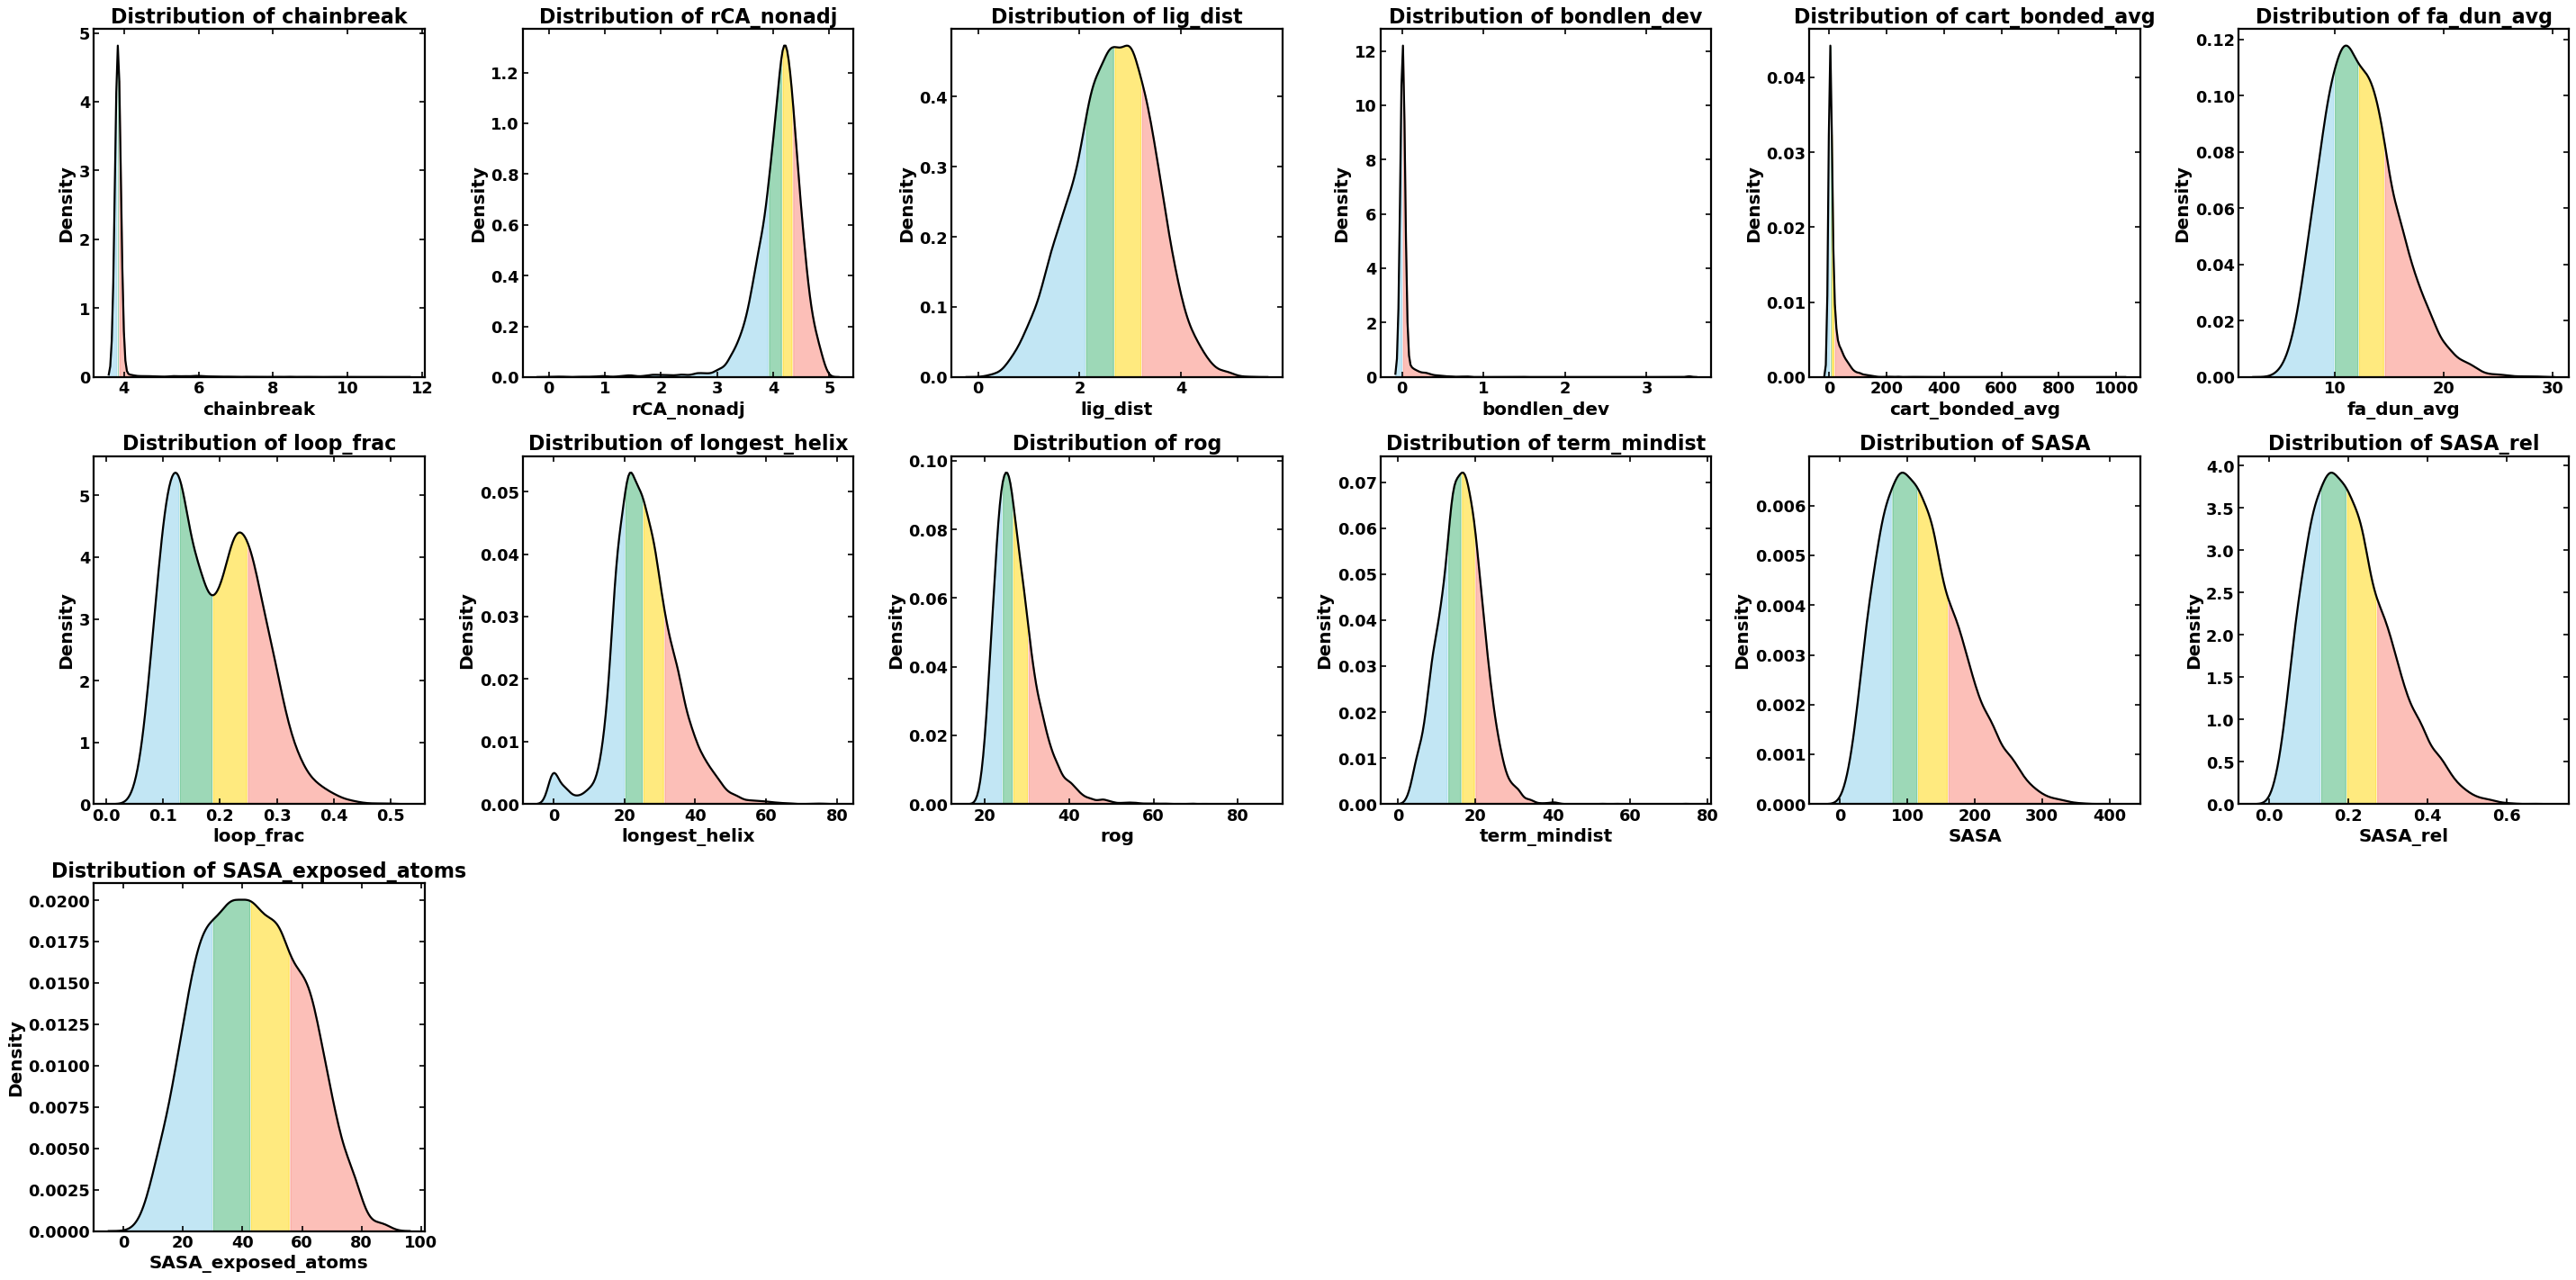

In [ ]:
##############################################
### PLOT THE DISTRIBUTION OF ALL THE STATS ###
##############################################

# INPUT COMBINED .SC FILE TO LOAD
file_path = f'{rf_flow_out_dir}production_run_250109/combined_ligand_RFflow_analysis.sc'

# Load the data
df = pd.read_csv(file_path, sep=r'\s+', engine='python')

##################
### PLOT STUFF ###
##################

# Define numerical columns, excluding 'loop_at_motif' if it exists
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = numerical_cols[numerical_cols != 'loop_at_motif']

quartile_colors = ['skyblue', 'mediumseagreen', 'gold', 'salmon']

# -------------------------- #
#  ADJUSTABLE FONT SCALES    #
# -------------------------- #
title_fontsize = 20
label_fontsize = 18
tick_fontsize  = 16

# Set up the grid for the subplots
num_cols_per_row = 6
num_rows = int(np.ceil(len(numerical_cols) / num_cols_per_row))
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(6 * num_cols_per_row, 6 * num_rows))

# Flatten axes for easier iteration; remove excess axes if needed
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    
    # 1) Draw the KDE line with a non-zero linewidth
    sns.kdeplot(
        data=df, x=col, ax=ax, fill=False, 
        linewidth=2, color='black'
    )
    
    # 2) Calculate quartiles
    q1, q2, q3 = df[col].quantile([0.25, 0.50, 0.75])
    
    # 3) Fill the area under the KDE curve in quartiles (if a line was created)
    if ax.lines:
        line = ax.lines[-1]
        x_data, y_data = line.get_data()
        
        ax.fill_between(
            x_data, y_data,
            where=(x_data < q1),
            color=quartile_colors[0], alpha=0.5
        )
        ax.fill_between(
            x_data, y_data,
            where=((x_data >= q1) & (x_data < q2)),
            color=quartile_colors[1], alpha=0.5
        )
        ax.fill_between(
            x_data, y_data,
            where=((x_data >= q2) & (x_data < q3)),
            color=quartile_colors[2], alpha=0.5
        )
        ax.fill_between(
            x_data, y_data,
            where=(x_data >= q3),
            color=quartile_colors[3], alpha=0.5
        )
    
    # Set title and labels with adjustable font sizes
    ax.set_title(f'Distribution of {col}', fontsize=title_fontsize, weight='semibold')
    ax.set_xlabel(f'{col}', fontsize=label_fontsize, weight='semibold')
    ax.set_ylabel('Density', fontsize=label_fontsize, weight='semibold')
    
    # Tick parameters: size, direction, etc.
    ax.tick_params(
        axis='both', which='major', 
        labelsize=tick_fontsize, 
        direction='in', length=5, width=1.5,
        top=True, right=True  # turn on top & right ticks
    )
    
    # Make spines visible on all four sides and set their width/color
    for side in ['left', 'right', 'top', 'bottom']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(2)
        ax.spines[side].set_edgecolor('black')

# Hide any excess axes
for ax in axes[len(numerical_cols):]:
    ax.remove()

plt.tight_layout()

# Save the figure to the specified directory
save_path = f'{cute_pics_dir}RFflow_stats_analysis_PRODUCTION.png'
plt.savefig(save_path, dpi=600)
plt.show()

The next cell is setup quite ideally so that you can look at the extrema for certain filtering criteria. Just choose a column to sort by and if you want it ascending or descending. Then it will print out the n_example of pdb files that passed all the filters and are the extrema for the sorting column you picked - you can use this to adjust cutoffs and inform the values you want to use. Just copy the list of pdb files and then do `pymol {paste copied list of pdb files}` in your terminal and you will see the pdb files ranked in order of the filtering column.

In [ ]:
##########################################
### INVESTIGATE IDEAL FILTER CRITERIA  ###
##########################################

### SHOW THE FIRST FEW ROWS OF THE FILTERED DF? ###
show_df_head = True

### SORTING PARAMETERS FOR FILTERED DF ###
sorting_col = "longest_helix"
sorting_ascending = False # smallest first = true
n_example = 20  # How many top examples to display

### INPUT DATAFRAME .SC FROM ANALYSIS FILTERING STEP ###
file_path = f'{rf_flow_out_dir}production_run_250109/combined_ligand_RFflow_analysis.sc' 
df = pd.read_csv(file_path, sep=r'\s+', engine='python') # Meant for .sc files

### MANDATORY (HARD-CODED) FILTERS ###
chainbreak = 4.5   # CA-distance threshold
lig_dist   = 2.5   # Clash distance with ligand
rCA_nonadj = 3.0   # Non-adjacent residues cannot be closer than this
bondlen_dev = 0.05  # Allowed bond-length deviation

### OPTIONAL FILTERS ###
loop_frac       = 0.5  # Usually 0.3
longest_helix   = 31   # Max helix length
rog             = 30   # Radius of gyration
term_mindist    = 8   # Terminus distance from ligand?
cart_bonded_avg = 7.5    # sidechain quality | smaller = better | recommended ~5
fa_dun_avg      = 15   # sidechain quality | smaller = better | recommended ~15

### SASA UPPER + LOWER FILTERS ###
SASA_rel_lower = 0.05   # Scale 0-1
SASA_rel_upper = 0.399   # Scale 0-1

### SASA EXPOSED ATOM FILTERS ###
SASA_exposed_atoms_lower = 0
SASA_exposed_atoms_upper = 66

### DEFINE FILTERS (adjust or comment out as desired) ###
filters = {
    ("chainbreak", "<="): chainbreak,
    ("lig_dist", ">="): lig_dist,
    ("rCA_nonadj", ">="): rCA_nonadj,
    ("bondlen_dev", "<="): bondlen_dev,
    ("loop_frac", "<="): loop_frac,
    ("longest_helix", "<="): longest_helix,
    ("rog", "<="): rog,
    ("SASA_rel", ">="): SASA_rel_lower,
    ("SASA_rel", "<="): SASA_rel_upper,
    ("SASA_exposed_atoms", ">="): SASA_exposed_atoms_lower,
    ("SASA_exposed_atoms", "<="): SASA_exposed_atoms_upper,
    ("term_mindist", ">="): term_mindist,
    ("cart_bonded_avg", "<="): cart_bonded_avg,
    ("fa_dun_avg", "<="): fa_dun_avg,
}

def filtering_df(dataframe_name, filters, target_df, print_stat=True):
    """
    Apply a set of filters to a DataFrame and print how many rows pass each one.
    Returns the filtered DataFrame.
    """
    if print_stat:
        print(f"[{dataframe_name}] ({len(target_df)} designs)")
    
    converted_filters = []
    for (key, operator_str), cutoff_value in filters.items():
        # Build a condition string, e.g. "target_df['chainbreak'] <= 4.5"
        filter_str = f"target_df['{key}'] {operator_str} {cutoff_value}"
        converted_filters.append(filter_str)
        
        if print_stat:
            pass_mask = eval(filter_str)
            count_passed = pass_mask.sum()
            pct_passed = (count_passed / len(target_df)) * 100
            print(
                f"# [ {key.ljust(19)} {operator_str.ljust(2)} "
                f"{str(cutoff_value).ljust(6)}]: "
                f"{str(count_passed).ljust(6)} ({pct_passed:.1f}%)"
            )
    
    # Combine all filters with logical AND
    final_mask = eval(" & ".join([f"({condition})" for condition in converted_filters]))
    filtered_df = target_df[final_mask]
    
    if print_stat:
        total_passed = len(filtered_df)
        pct_passed = (total_passed / len(target_df)) * 100
        print(f"# [             ALL              ]: {str(total_passed).ljust(6)} ({pct_passed:.1f}%)")
    
    return filtered_df

### APPLY FILTERS ###
filtered_RFflow_df = filtering_df("RFflow", filters, df)
filter_rate = (len(filtered_RFflow_df) / len(df)) * 100.0

print(f"\n{len(filtered_RFflow_df)} of {len(df)} designs ({round(filter_rate, 3)}%) passed\n")

### OPTIONALLY SHOW FIRST n ROWS SORTED BY A SPECIFIC COLUMN ###
if show_df_head:
    print(f"# SORTED BY [{sorting_col}] IN [{'Descending' if not sorting_ascending else 'Ascending'}] ORDER:")
    filtered_RFflow_df.sort_values(by=sorting_col, ascending=sorting_ascending, inplace=True)
    top_descriptions = filtered_RFflow_df['description'].head(n_example).tolist()
    print(' '.join(top_descriptions))
    print('')
    print(filtered_RFflow_df.head(n_example))

[RFflow] (8192 designs)
# [ chainbreak          <= 4.5   ]: 7936   (96.9%)
# [ lig_dist            >= 2.5   ]: 4810   (58.7%)
# [ rCA_nonadj          >= 3.0   ]: 8044   (98.2%)
# [ bondlen_dev         <= 0.05  ]: 7421   (90.6%)
# [ loop_frac           <= 0.5   ]: 8192   (100.0%)
# [ longest_helix       <= 31    ]: 6299   (76.9%)
# [ rog                 <= 30    ]: 6119   (74.7%)
# [ SASA_rel            >= 0.05  ]: 7995   (97.6%)
# [ SASA_rel            <= 0.399 ]: 7786   (95.0%)
# [ SASA_exposed_atoms  >= 0     ]: 8192   (100.0%)
# [ SASA_exposed_atoms  <= 66    ]: 7422   (90.6%)
# [ term_mindist        >= 8     ]: 7660   (93.5%)
# [ cart_bonded_avg     <= 7.5   ]: 4436   (54.2%)
# [ fa_dun_avg          <= 15    ]: 6492   (79.2%)
# [             ALL              ]: 1089   (13.3%)

1089 of 8192 designs (13.293%) passed

# SORTED BY [longest_helix] IN [Descending] ORDER:
/net/scratch/woodbuse/zn_hydrolase_ultraOPT/design_campaign1_241122/rf_flow_out/production_run_250109/group2_GLU_in_4m

/scratch/woodbuse/1915796/ipykernel_1525112/4064921871.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_RFflow_df.sort_values(by=sorting_col, ascending=sorting_ascending, inplace=True)


#### Execute the Filtering & Filter by Catalytic Residue Distance

In [ ]:
###########################################################################
### RUN PROCESS RF-FLOW OUTPUTS (JUST TO INVESTIGATE FILTERING METRICS) ###
###########################################################################

### SET LIGAND NAMES (LIGAND NAMES MUST BE IN EACH PDB BASENAME) ###
multiple_ligand_names = {"SZA", "SZB", "SZC", "SZD"}  # Can be a single ligand too

### INPUT STRUCTURE DIRECTORIES ###
rf_flow_bbs_to_analyze_DIR = f"{rf_flow_out_dir}production_run_250109/"
combined_input_ligands_DIR = f"{theozymes_dir}combined_theozymes/theozymes_with_crucial_hydrogen/"  # Ensure this is not the ORI token stuff
params_path_DIR = f"{theozymes_dir}combined_theozymes/params/"  # Ensure params pdb file is here too

### PROTEIN QUALITY INPUT VARIABLES ###
rog           = 30  # Radius of gyration
longest_helix = 31
loop_limit    = 0.5  # Default is 0.3, proportion of protein that is loop
lig_dist      = 2.5  # Clash distance with ligand

### LIGAND-PROTEIN QUALITY INPUT VARIABLES ###
ligand_exposed_atoms = "C8 C13 C14 C15 C16 C17 C18"  # Atoms to be exposed for filtering (looks for SASA > value)
exposed_atom_SASA    = 0  # Not relative SASA | lower limit
SASA_limit           = 0.399  # Upper limit for SASA_rel
terminus_dist_limit  = 8  # Default is 15 Å, terminus distance from ligand must exceed this value

### SIDE CHAIN QUALITY INPUT VARIABLES ###
bondlen_dev     = 0.05  # Allowed bond-length deviation
cart_bonded_avg = 7.0  # Sidechain quality | smaller = better | recommended ~5
fa_dun_avg      = 15  # Sidechain quality | smaller = better | recommended ~15

### INPUT FLAGS ###
ref_catres    = "A1 B2 C3 D4"     # Reference catalytic residues 
loop_catres   = True  # By making this true, you enable the catalytic residues to be on loops (means you are okay with it).
fix_flag      = True  # Optional flag | None if you do not want it | True if you do
rethread_flag = None  # Optional flag | None if you do not want it | True if you do
analyze_flag  = None  # Optional flag | None if you do not want it | True if you do

### CONSTANTS ###
apptainer = "/net/software/containers/users/ikalvet/allmighty.sif"
script    = "/net/software/lab/scripts/enzyme_design/diffusion_utils/process_diffusion_outputs.py"

### GENERATE COMMANDS ###
for ligand_name in multiple_ligand_names:
    ### INPUT STRUCTURES ###
    pdb_path = f"{rf_flow_bbs_to_analyze_DIR}*{ligand_name}*.pdb"
    ref_path = f"{combined_input_ligands_DIR}*{ligand_name}*.pdb"
    params_path = f"{params_path_DIR}{ligand_name}.params"
    
    # Initialize command
    command = (f"{apptainer} {script} "
               f"--pdb {pdb_path} "
               f"--ref {ref_path} "
               f"--params {params_path} "

               f"--rog {rog} "
               f"--longest_helix {longest_helix} "
               f"--loop_limit {loop_limit} "
               f"--lig_dist {lig_dist} "

               f"--ligand_exposed_atoms {ligand_exposed_atoms} "
               f"--exposed_atom_SASA {exposed_atom_SASA} "
               f"--SASA_limit {SASA_limit} "
               f"--term_limit {terminus_dist_limit} "

               f"--bondlen_dev {bondlen_dev} "
               f"--cart_bonded {cart_bonded_avg} "
               f"--fa_dun {fa_dun_avg} "

               f"--ref_catres {ref_catres} "
              )

    # Add optional flags
    if loop_catres:
        command += f"--loop_catres "
    if fix_flag:
        command += f"--fix "
    if rethread_flag:
        command += f"--rethread "
    if analyze_flag:
        command += f"--analyze "
    
    # Print the command for the current ligand
    print(command)
    print()
    print(f"mv diffusion_analysis.sc RFflow_analysis_{ligand_name}.sc")
    print()

/net/software/containers/users/ikalvet/allmighty.sif /net/software/lab/scripts/enzyme_design/diffusion_utils/process_diffusion_outputs.py --pdb /net/scratch/woodbuse/zn_hydrolase_ultraOPT/design_campaign1_241122/rf_flow_out/production_run_250109/*SZB*.pdb --ref /home/woodbuse/projects/zinc_hydrolase/single_zn_ultra_optimization_4muPA/theozymes/combined_theozymes/theozymes_with_crucial_hydrogen/*SZB*.pdb --params /home/woodbuse/projects/zinc_hydrolase/single_zn_ultra_optimization_4muPA/theozymes/combined_theozymes/params/SZB.params --rog 30 --longest_helix 31 --loop_limit 0.5 --lig_dist 2.5 --ligand_exposed_atoms C8 C13 C14 C15 C16 C17 C18 --exposed_atom_SASA 0 --SASA_limit 0.399 --term_limit 8 --bondlen_dev 0.05 --cart_bonded 7.0 --fa_dun 15 --ref_catres A1 B2 C3 D4 --loop_catres --fix 

mv diffusion_analysis.sc RFflow_analysis_SZB.sc

/net/software/containers/users/ikalvet/allmighty.sif /net/software/lab/scripts/enzyme_design/diffusion_utils/process_diffusion_outputs.py --pdb /net/scr

Now I decided to do some filtering in the sequence space. Turns out, there are pretty distinct motifs for zinc binding: https://pmc.ncbi.nlm.nih.gov/articles/PMC3268031/ \
**HExxH** motif forming an α-helix \
**HxxE(D)-aan-H** in carboxypeptidase family \
**HxD-aa12-H-aa12-H** matrix metalloprotease \
**HELLGH** in dipeptidyl peptidase & three kinds of monooxygenases